In [1]:
import networkx as nx
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import json
from tqdm.notebook import tqdm
tqdm.pandas()

import math


%matplotlib inline

* ~~jak czasy przejazdu po trasach maja sie do godzin szczytowych vs luznych~~
* ~~zależność czasów dojazdu i prędkości autobusów od umiejscowienia na mapie wrocławia~~
* zależność opóźnień od umiejscowienia na mapie wrocławia
* czy daloby sie wykryc odcinki, gdzie autobus moglby nadrobic spoznienia?
* jak dlugo autobus jechal miedzy przystankami w stosunku do tego ile faktycznie moglby jechac
* wytrenowac model przewidujący opóźnienia (wagi krawędzi w grafie)
* wyrysowanie awarii w poszczegolnych rejonach wroclawia

## Data

We obtain data from Overpass (http://overpass-turbo.eu/) using following querry:

```
[out:json][timeout:25];
(
  area['name'='Wrocław'];
  //(node['railway'='tram_stop'](area););
  //(node['highway'='bus_stop'](area););
  (relation['route'='tram'](area);); // dla linii tramwajowych
  (relation['route'='bus'](area);); // dla linii autobusowych
);
out body;
>;
out skel qt;wroc = ox.geocode_to_gdf("Wrocław, Poland", which_result=1)
```

***

### Wroclaw road graph

In [2]:
roads_graph = ox.graph_from_place(
    "Wrocław, Poland", 
    network_type="drive",
)

### **Wrocław open data**

In [3]:
routes_od = pd.read_csv("dane/routes.txt")
stops_od = pd.read_csv("dane/stops.txt")
shapes_od = pd.read_csv("dane/shapes.txt")
trips_od = pd.read_csv("dane/trips.txt")
stop_times_od = pd.read_csv("dane/stop_times.txt")

stops_od = gpd.GeoDataFrame(stops_od, geometry=gpd.points_from_xy(stops_od.stop_lon.values, stops_od.stop_lat.values), crs='WGS84').drop(["stop_lat", "stop_lon"], axis=1)

stops_od.rename(columns={"stop_name": "name"}, inplace=True)
stops_od['geometry'] = [Point(round(el, 3) for el in p.coords[0]) for p in stops_od.geometry.values]
stops_od['coords'] = [p.coords[0] for p in stops_od.geometry.values]

shapes_od = gpd.GeoDataFrame(shapes_od, geometry=gpd.points_from_xy(shapes_od.shape_pt_lon.values, shapes_od.shape_pt_lat.values), crs='WGS84').drop(["shape_pt_lat", "shape_pt_lon"], axis=1)

routes = pd.read_csv("routes_df.csv")

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### **OSMNX**

In [4]:
bus_stops_ox = ox.geometries_from_place("Wrocław, Poland", tags={'highway': 'bus_stop'}).loc['node']
bus_stops_ox.drop('name', axis=1, inplace=True)

tram_stops_ox = ox.geometries_from_place("Wrocław, Poland", tags={'railway': 'tram_stop'}).loc['node']
tram_stops_ox.drop('name', axis=1, inplace=True)

wroc = ox.geocode_to_gdf("Wrocław, Poland")

### **Overpass**

In [5]:
tram_op = gpd.read_file("dane/tram.geojson")
bus_op = gpd.read_file("dane/bus.geojson")


tram_op = tram_op[tram_op.within(wroc.iloc[0].geometry.buffer(0.05))]
bus_op = bus_op[bus_op.within(wroc.iloc[0].geometry.buffer(0.05))]

bus_stops_op = bus_op[bus_op['route'] != 'bus'].dropna(axis=1, how='all')
bus_stops_op['osmid'] = [int(el.split("/")[1]) for el in bus_stops_op['id']]
bus_stops_op.drop(['id', '@id'], axis=1, inplace=True)
bus_routes_op = bus_op[bus_op['route'] == 'bus']

tram_stops_op = tram_op[tram_op['route'] != 'tram'].dropna(axis=1, how='all')
tram_stops_op['osmid'] = [int(el.split("/")[1]) for el in tram_stops_op['id']]
tram_stops_op.drop(['id', '@id'], axis=1, inplace=True)
tram_routes_op = tram_op[tram_op['route'] == 'tram']

## Mergowanie danych

### Bus

In [6]:
bus_stops_ox['osmid'] = bus_stops_ox.index.values
bus_stops_ox['coords'] = [p.coords[0] for p in [Point(round(el, 3) for el in p.coords[0]) for p in bus_stops_ox.geometry.values]]

bus_stops_final = bus_stops_ox.merge(stops_od.drop('geometry', axis=1), on="coords")[['osmid', 'stop_id', 'stop_code', 'name', 'geometry']]

### Tram

In [7]:
tram_stops_ox['osmid'] = tram_stops_ox.index.values
tram_stops_ox['coords'] = [p.coords[0] for p in [Point(round(el, 3) for el in p.coords[0]) for p in tram_stops_ox.geometry.values]]

tram_stops_final = tram_stops_ox.merge(stops_od.drop('geometry', axis=1), on="coords")[['osmid', 'stop_id', 'stop_code', 'name', 'geometry']]

# **Changing CRS**

In [8]:
wroc.to_crs(crs='EPSG:3395', inplace=True)
stops_od.to_crs(crs='EPSG:3395', inplace=True)

bus_routes_op.to_crs(crs='EPSG:3395', inplace=True)
bus_stops_ox.to_crs(crs='EPSG:3395', inplace=True)
bus_stops_op.to_crs(crs='EPSG:3395', inplace=True)
bus_stops_final.to_crs(crs='EPSG:3395', inplace=True)

tram_routes_op.to_crs(crs='EPSG:3395', inplace=True)
tram_stops_ox.to_crs(crs='EPSG:3395', inplace=True)
tram_stops_op.to_crs(crs='EPSG:3395', inplace=True)
tram_stops_final.to_crs(crs='EPSG:3395', inplace=True)

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# **Creating routes dataframe (all trip times)**

In [687]:
trips_times = stop_times_od.merge(trips_od, on='trip_id')

arrival_hours = np.array([int(t.split(":")[0]) for t in trips_times['arrival_time'].values])
arrival_minutes = np.array([int(t.split(":")[1]) for t in trips_times['arrival_time'].values])

departure_hours = np.array([int(t.split(":")[0]) for t in trips_times['departure_time'].values])
departure_minutes = np.array([int(t.split(":")[1]) for t in trips_times['departure_time'].values])

trips_times['arrival_time'] = [f"{str(hour % 24).zfill(2)}:{str(minute).zfill(2)}:00" for hour, minute in zip(arrival_hours, arrival_minutes)]
trips_times['departure_time'] = [f"{str(hour % 24).zfill(2)}:{str(minute).zfill(2)}:00" for hour, minute in zip(departure_hours, departure_minutes)]

from tqdm.notebook import tqdm

unique_trips = trips_times['trip_id'].unique()

routes = []

for trip in tqdm(unique_trips):
    trip_times = trips_times[trips_times['trip_id'] == trip] 
    trip_times['arrival_time'] = pd.to_datetime(trip_times['arrival_time']).values
    trip_times['departure_time'] = pd.to_datetime(trip_times['departure_time']).values
    for first_stop, second_stop in zip(trip_times[:-1].iterrows(), trip_times[1:].iterrows()):
        first_stop = first_stop[1]
        second_stop = second_stop[1]
        start_time = first_stop['departure_time']
        end_time = second_stop['arrival_time']
        duration = (end_time - start_time).seconds // 60
        routes.append({
            'trip_id': trip,
            'source_stop_id': first_stop['stop_id'],
            'target_stop_id': second_stop['stop_id'],  
            'duration': duration,
            'direction': first_stop['direction_id'],
            'route_id': first_stop['route_id'],
            'time': start_time.time(),
        })
        
routes_df = pd.DataFrame.from_dict(routes)

routes_df['hour'] = routes_df['time'].apply(lambda x: x.hour)
routes_df['source-target'] = routes_df[['source_stop_id', 'target_stop_id']].apply(lambda x: f"{x['source_stop_id']}-{x['target_stop_id']}", axis=1)

routes_df.to_csv("routes_df.csv", index=False)

  0%|          | 0/40378 [00:00<?, ?it/s]

/tmp/ipykernel_46/247915293.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip_times['arrival_time'] = pd.to_datetime(trip_times['arrival_time'])
/tmp/ipykernel_46/247915293.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip_times['departure_time'] = pd.to_datetime(trip_times['departure_time'])


In [140]:
def add_velocity_and_distance(row):
    duration = row['duration']
    start_point = row['source_geometry']
    end_point = row['target_geometry']
    line_distance = start_point.distance(end_point)
    line_velocity = line_distance / (duration / 60 / 60) / 1000 if duration > 0 else 60
    mid_x = (start_point.coords[0][0] + end_point.coords[0][0]) / 2
    mid_y = (start_point.coords[0][1] + end_point.coords[0][1]) / 2
    midpoint = Point(mid_x, mid_y)
    row['line_distance'] = line_distance
    row['line_velocity'] = line_velocity
    row['geometry'] = midpoint
    return row

routes_df = routes_df \
    .merge(stops_od.rename(columns={'stop_id': 'target_stop_id'})[['target_stop_id', 'geometry']], on='target_stop_id') \
    .rename(columns={'geometry': 'target_geometry'}) \
    .merge(stops_od.rename(columns={'stop_id': 'source_stop_id'})[['source_stop_id', 'geometry']], on='source_stop_id') \
    .rename(columns={'geometry': 'source_geometry'})

routes_df = routes_df.progress_apply(add_velocity_and_distance, axis=1)
routes_df.to_csv("routes_df.csv", index=False)

  0%|          | 0/969556 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Load routes_df

In [141]:
routes_df = pd.read_csv("routes_df.csv")
routes_df['duration'] = routes_df['duration']*60 # minutes into seconds

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [179]:
routes_df['source_geometry'] = routes_df['source_geometry'].apply(lambda x: Point(np.array(x.replace("(", "").replace(")", "").split(" ")[1:], float)))
routes_df['target_geometry'] = routes_df['target_geometry'].apply(lambda x: Point(np.array(x.replace("(", "").replace(")", "").split(" ")[1:], float)))
routes_df['geometry'] = routes_df['geometry'].apply(lambda x: Point(np.array(x.replace("(", "").replace(")", "").split(" ")[1:], float)))

## Creating graph using info from Wrocław open data

### nodes

In [9]:
from copy import deepcopy

temp_stops_df = deepcopy(pd.concat([bus_stops_final, tram_stops_final]))

stops_nodes = gpd.GeoDataFrame(temp_stops_df[['geometry', 'osmid', 'stop_id']])
stops_nodes['x'] = [p.coords[0][0] for p in temp_stops_df.geometry.values]
stops_nodes['y'] = [p.coords[0][1] for p in temp_stops_df.geometry.values]
stops_nodes.set_index('osmid', inplace=True)
stops_nodes.to_crs(crs='EPSG:3395', inplace=True)

### edges

In [11]:
mean_routes_df = routes_df.drop(['direction', 'hour', 'source_stop_id', 'target_stop_id'], axis=1).groupby(['source-target']).mean() \
    .merge(routes_df[['source-target', 'source_geometry', 'target_geometry']], on=['source-target']) \
    .astype(str) \
    .drop_duplicates().reset_index(drop=True)

mean_routes_df['source_geometry'] = mean_routes_df['source_geometry'].apply(lambda x: Point(np.array(x.replace("(", "").replace(")", "").split(" ")[1:], float)))
mean_routes_df['target_geometry'] = mean_routes_df['target_geometry'].apply(lambda x: Point(np.array(x.replace("(", "").replace(")", "").split(" ")[1:], float)))

mean_routes_df['duration'] = mean_routes_df['duration'].astype(float)
mean_routes_df['line_velocity'] = mean_routes_df['line_velocity'].astype(float)
mean_routes_df['line_distance'] = mean_routes_df['line_distance'].astype(float)

In [12]:
from shapely.geometry import LineString

rows = []
for edge in mean_routes_df.iterrows():
    edge = edge[1]
    source, target = np.array(edge['source-target'].split("-"), int)
    if source in stops_nodes['stop_id'].values and target in stops_nodes['stop_id'].values:
        source = temp_stops_df[temp_stops_df['stop_id'] == source].iloc[0]
        target = temp_stops_df[temp_stops_df['stop_id'] == target].iloc[0]
        start_point, end_point = edge['source_geometry'], edge['target_geometry']
        rows.append({
            'u': source['osmid'],
            'v': target['osmid'],
            'line_distance': edge['line_distance'],
            'line_velocity': edge['line_velocity'],
            'geometry': LineString([start_point.coords[0], end_point.coords[0]]),
            'source_stop_id': source['stop_id'],
            'target_stop_id': target['stop_id'],
            "duration": edge['duration'],
            "key": 0
        })
        
stops_edges = gpd.GeoDataFrame.from_dict(rows, crs='EPSG:3395').set_index(['u', 'v', 'key'])

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:475: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  return GeoDataFrame(dataframe, geometry=geometry, crs=crs)


In [13]:
G = ox.graph_from_gdfs(
    stops_nodes.drop('stop_id', axis=1).drop_duplicates(),
    stops_edges
)

In [129]:
def parse_str_duration_to_seconds(duration):
    minutes, seconds = duration.split(':')[1:]
    minutes, seconds = float(minutes), float(seconds)
    return minutes*60 + seconds


recorded_trips = pd.read_csv("data/recorded_trips.csv", index_col=0)
recorded_trips['time'] = [start_time.split('+')[0].split(' ')[1] for start_time in recorded_trips['start_time'].values] # chcemy tylko godziny i minuty
recorded_trips['hour'] = [int(time.split(':')[0]) for time in recorded_trips['time']]
recorded_trips = recorded_trips.rename(columns={'destination_id': 'target_code', 'source_id': 'source_code'}).dropna()
recorded_trips['source_code'] = recorded_trips['source_code'].astype(int)
recorded_trips['target_code'] = recorded_trips['target_code'].astype(int)
recorded_trips = recorded_trips[~recorded_trips['duration'].str.contains('-')] # usuwamy -1 days, do naprawyy
recorded_trips['duration'] = recorded_trips['duration'].apply(parse_str_duration_to_seconds) # zamieniamy stringi na sekundy
recorded_trips = recorded_trips.drop(['source_name', 'destination_name', 'line', 'k', 'likely_incorrect', 'start_time', 'end_time'], axis=1)

In [130]:
recorded_trips = recorded_trips.merge(
    stops_od[['stop_code', 'geometry', 'stop_id']].rename(columns={'stop_code': 'source_code'}), 
    on="source_code"
).rename(columns={'geometry': 'source_geometry', 'stop_id': 'source_stop_id'})

recorded_trips = recorded_trips.merge(
    stops_od[['stop_code', 'geometry', 'stop_id']].rename(columns={'stop_code': 'target_code'}), 
    on="target_code"
).rename(columns={'geometry': 'target_geometry', 'stop_id': 'target_stop_id'})

recorded_trips = recorded_trips.drop(['source_code', 'target_code'], axis=1)
recorded_trips['source-target'] = recorded_trips[['source_stop_id', 'target_stop_id']].apply(lambda x: f"{x['source_stop_id']}-{x['target_stop_id']}", axis=1)

In [145]:
recorded_trips = recorded_trips.progress_apply(add_velocity_and_distance, axis=1)

  0%|          | 0/148013 [00:00<?, ?it/s]

/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


# Delete highest values (some outliers?)

In [249]:
_routes_df = routes_df[routes_df['duration'] <= 540]
_recorded_trips = recorded_trips[recorded_trips['duration'] <= 540]

---
---
---

# **Visualisation**

## **Graph of all Wrocław roads**

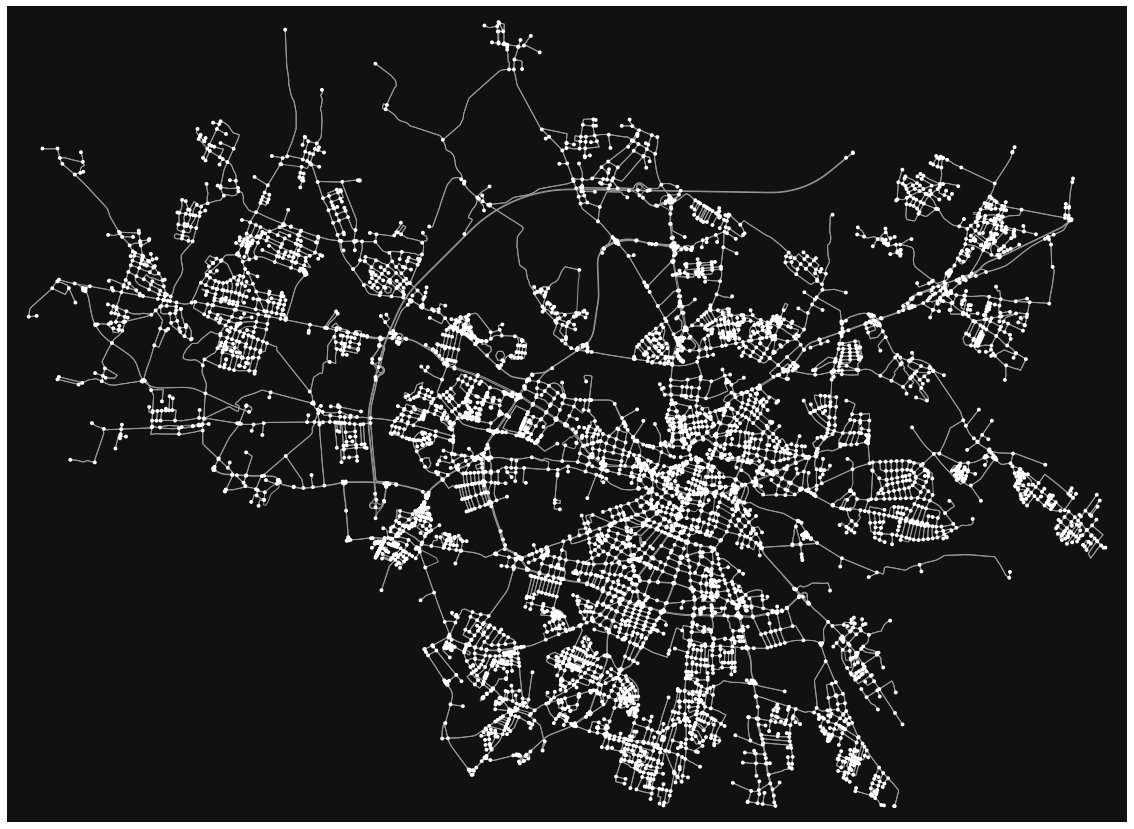

(<Figure size 2160x1080 with 1 Axes>, <AxesSubplot:>)

In [393]:
ox.plot_graph(roads_graph, figsize=(30, 15))

## **Graph of all Wrocław bus and tram roads**

<AxesSubplot:>

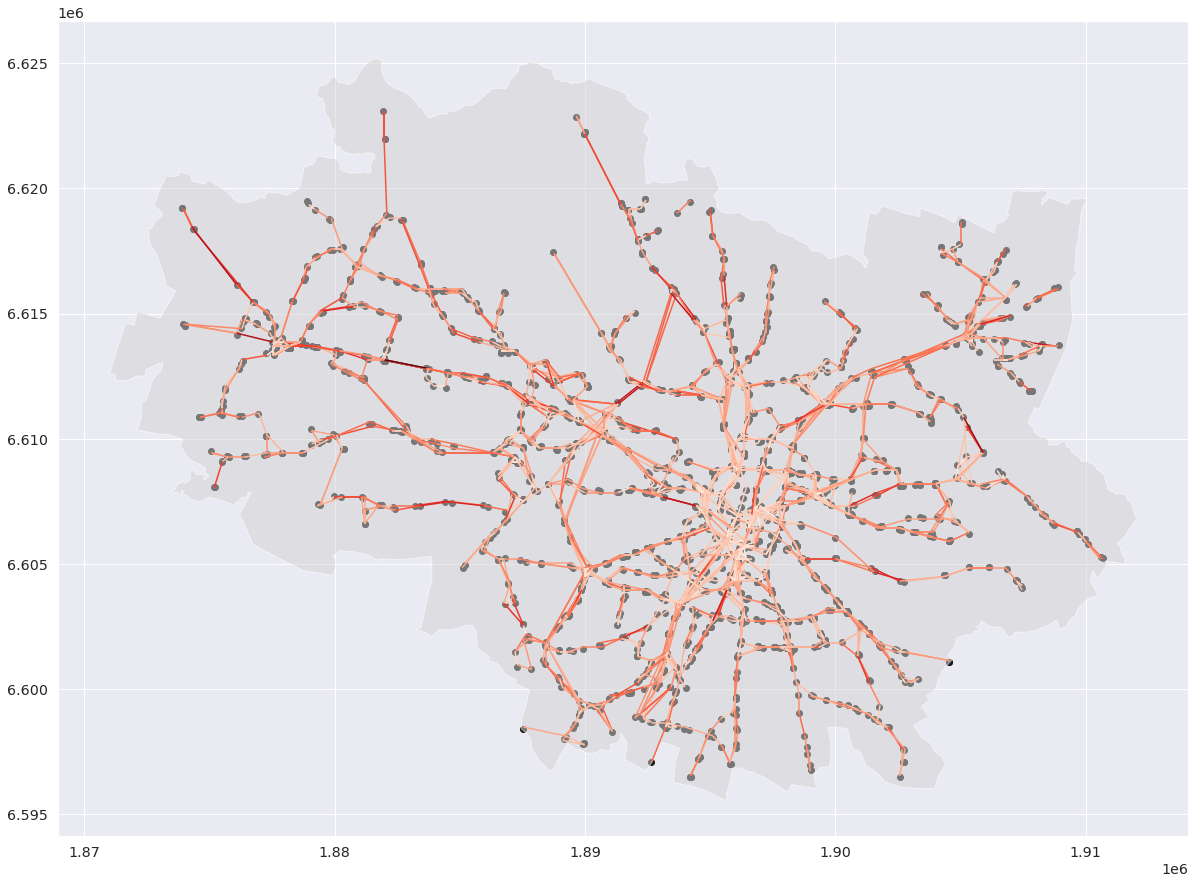

In [1036]:
fig, ax = plt.subplots(figsize=(30, 15))

cmap = plt.get_cmap("Reds")
min_max = lambda x: (x - x.min()) / (x.max() - x.min())
ec = [cmap(x) for x in min_max(stops_edges.line_velocity.values)]
# ox.plot_graph(G, ax=ax, node_color='k', edge_color=ec)

stops_edges.plot(edgecolor=ec, ax=ax)
stops_nodes.plot(ax=ax, color='k')
wroc.plot(ax=ax, color='lightgrey', alpha=0.5)

## **Stops and routes**

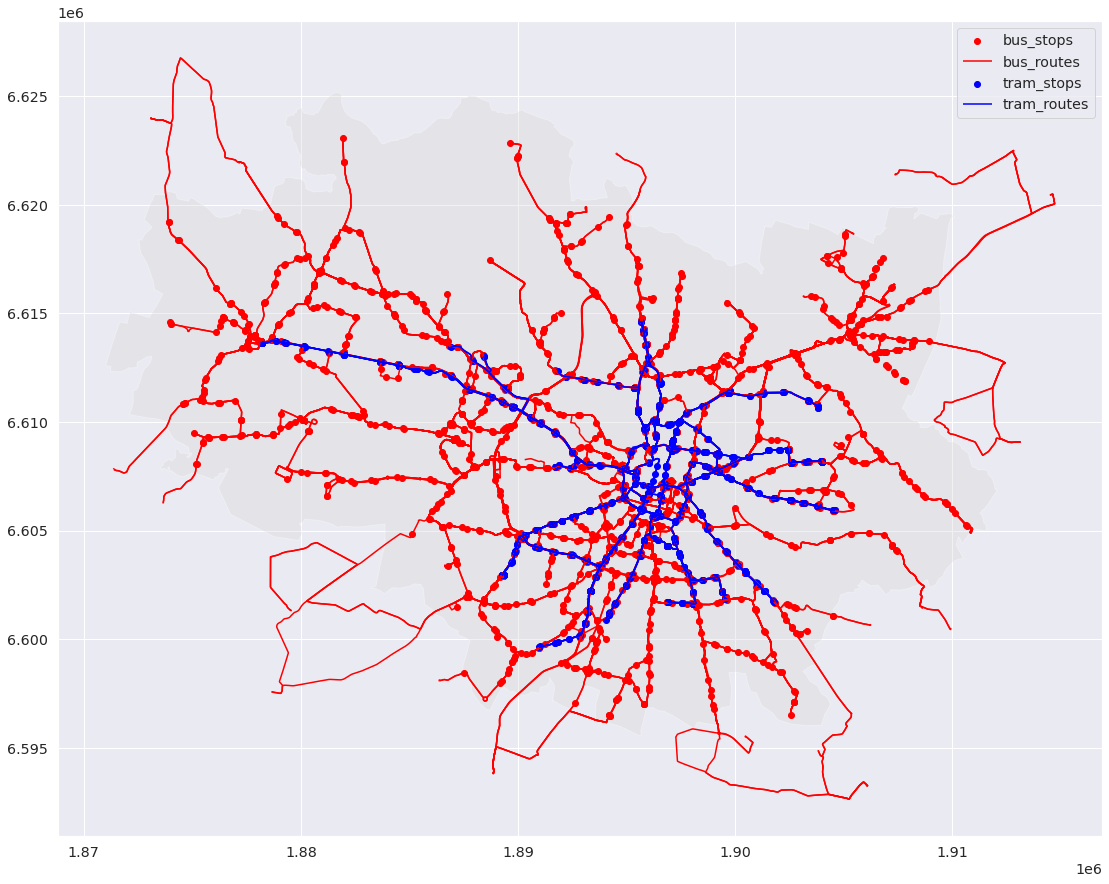

In [341]:
fig, ax = plt.subplots(figsize=(35, 15))

wroc.plot(ax=ax, color='lightgrey', alpha=0.3)

bus_stops_final.plot(color='red', ax=ax, label='bus_stops')
bus_routes_op.plot(color='red', ax=ax, label='bus_routes')

tram_stops_final.plot(color='blue', ax=ax, label='tram_stops')
tram_routes_op.plot(color='blue', ax=ax, label='tram_routes')

plt.legend()

***

## **Routes x Hour** 

### duration

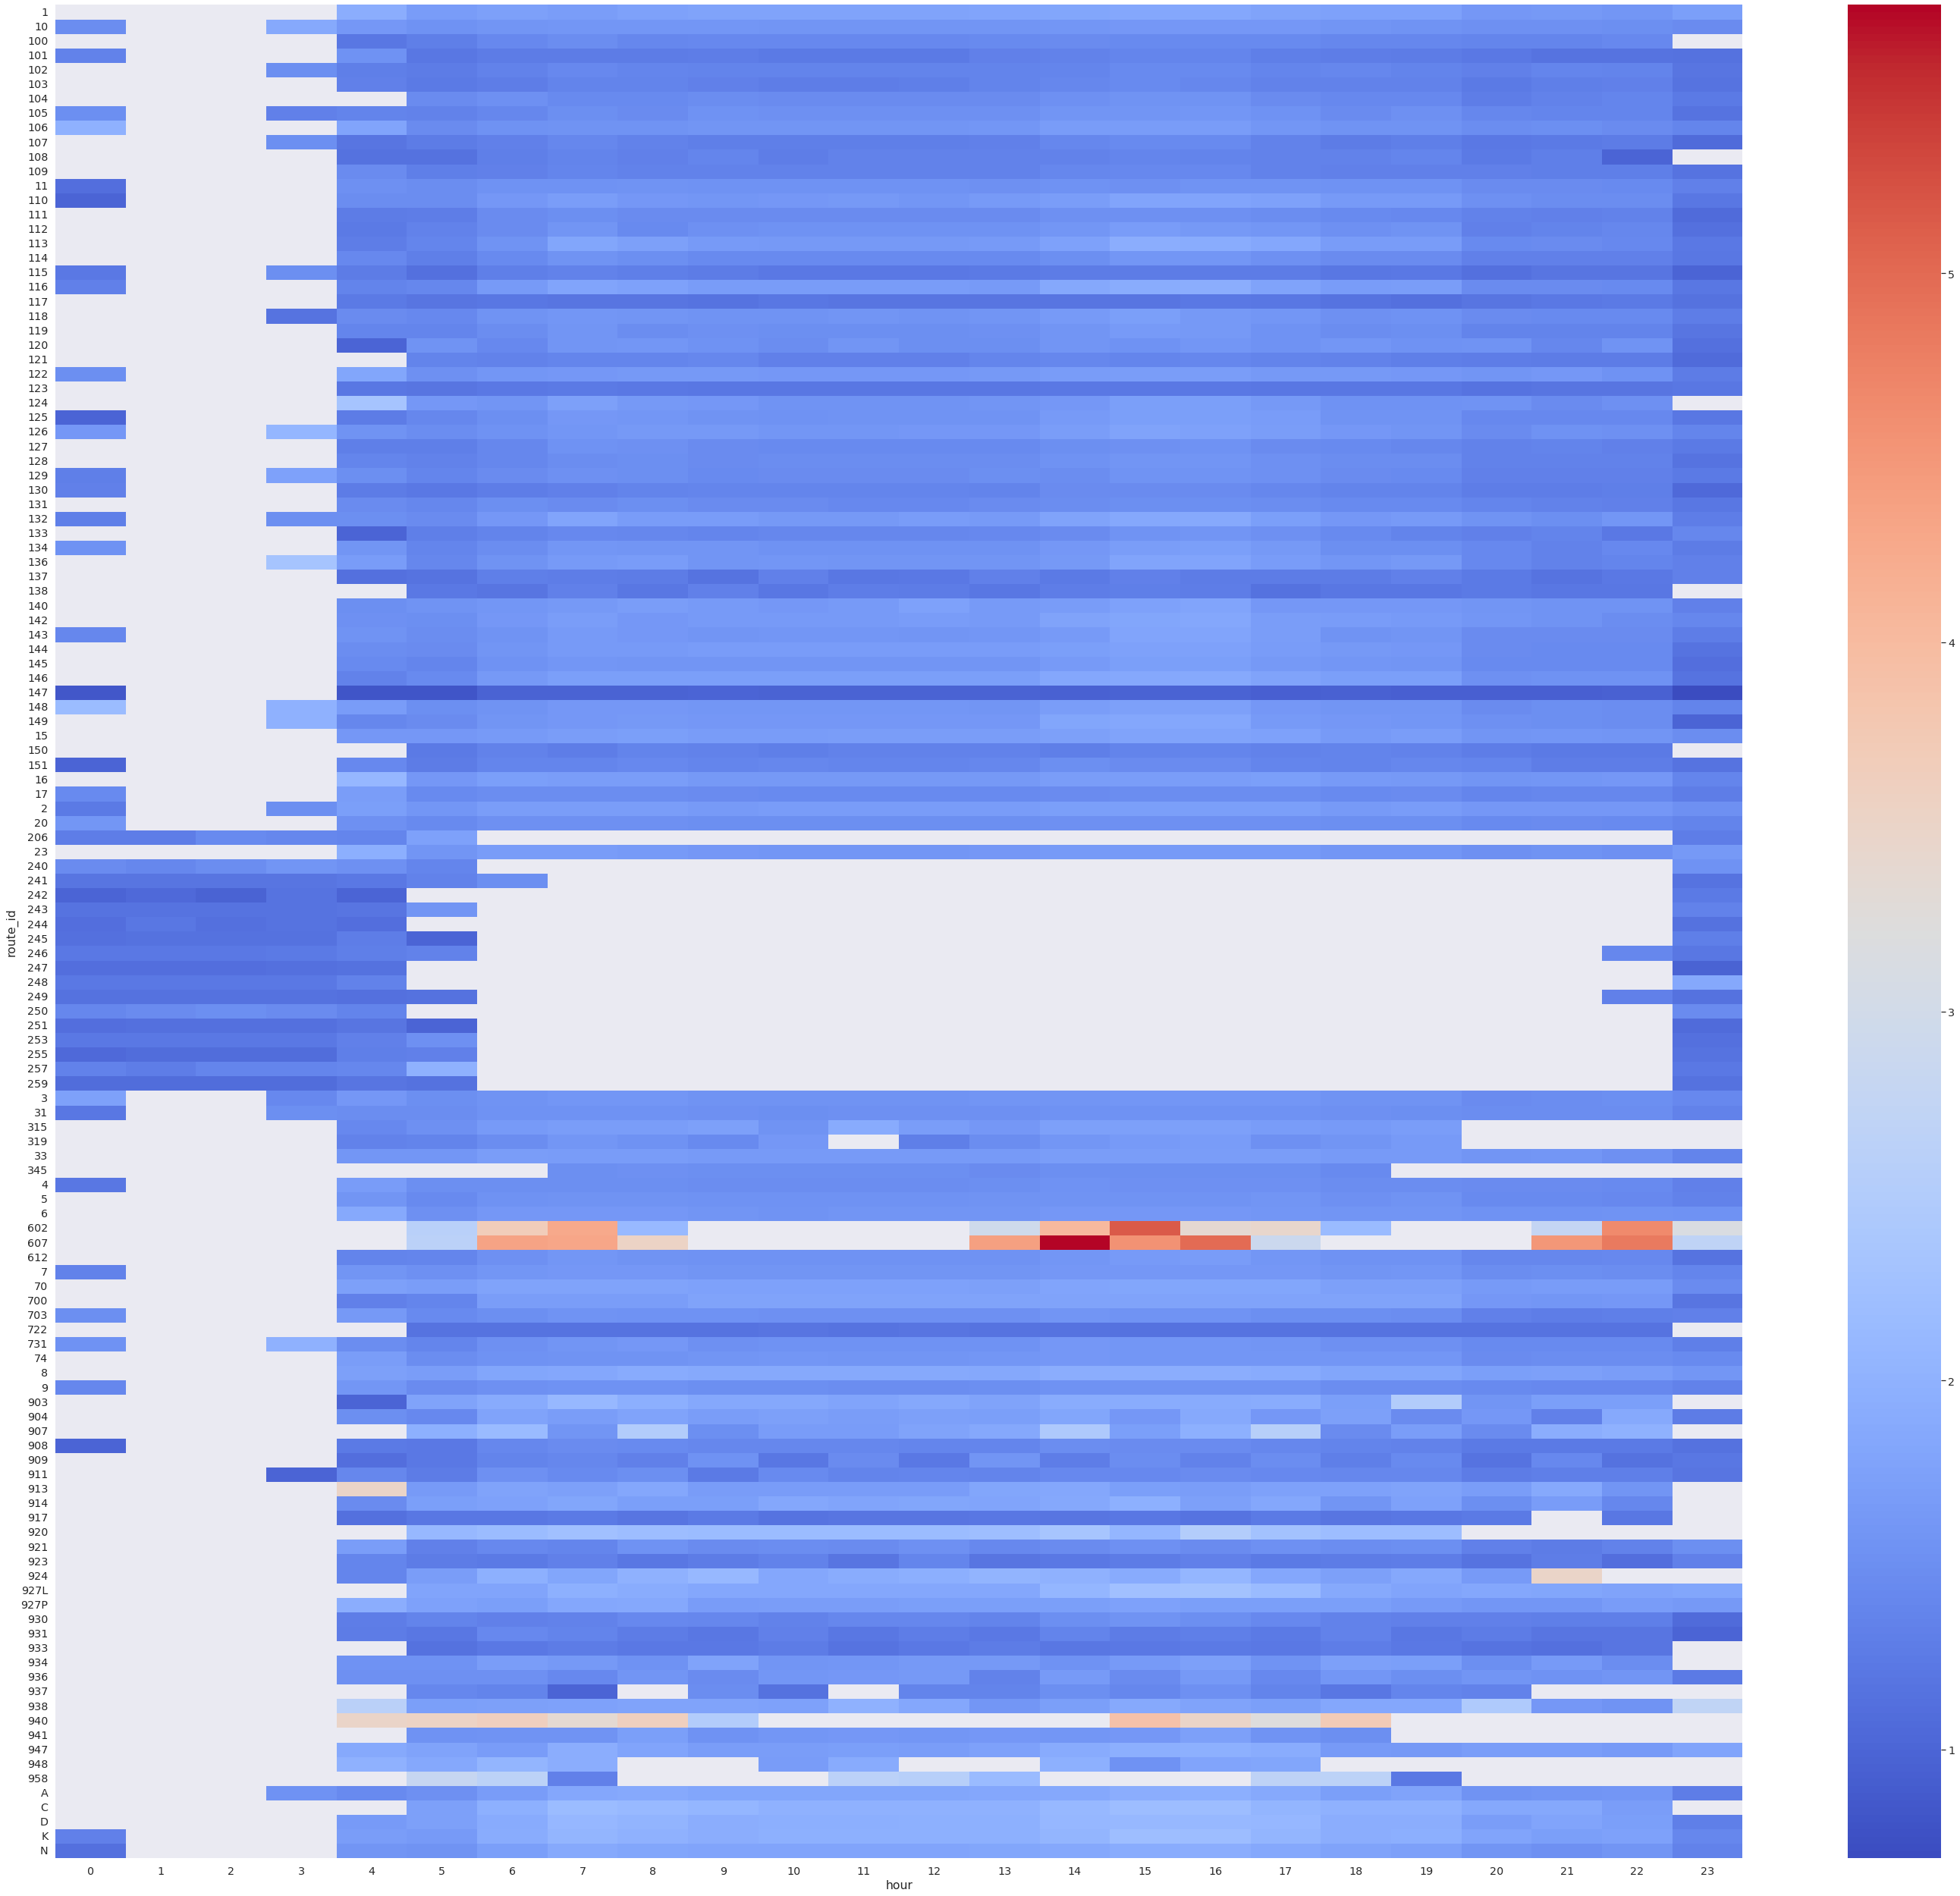

In [312]:
df = routes_df.groupby(['route_id', 'hour']).mean().reset_index()[['route_id', 'hour', 'duration']]

pivot = df.pivot(index='route_id', columns='hour', values='duration')
plt.figure(figsize=(40, 35))
sns.heatmap(pivot, cmap='coolwarm')
plt.tight_layout()
plt.savefig("route_hour_duration.eps")

### velocity, scheduled (in line dist)

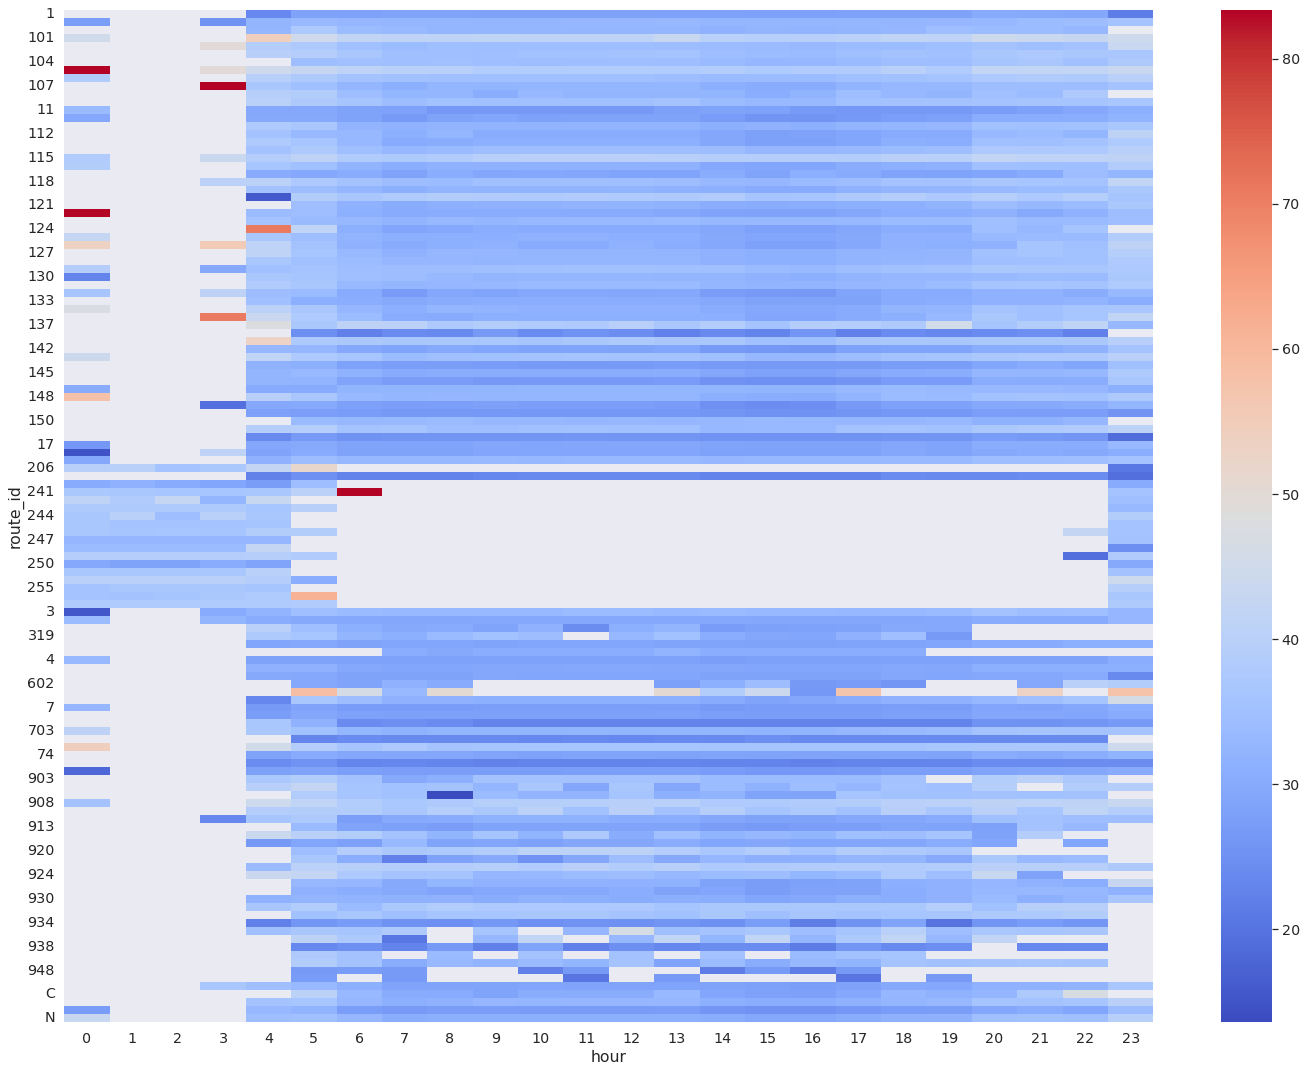

In [539]:
df = routes_df_2.groupby(['route_id', 'hour']).mean().reset_index()[['route_id', 'hour', 'line_velocity']]

pivot = df.pivot(index='route_id', columns='hour', values='line_velocity')
plt.figure(figsize=(20, 15))
sns.heatmap(pivot, cmap='coolwarm')
plt.tight_layout()
plt.savefig("route_hour_line_velocity.eps")

### velocity, scheduled (in real dist)

### delay

### velocity, real world data (in real dist)

***

## **mean Hour** 

### duration (scheduled data)

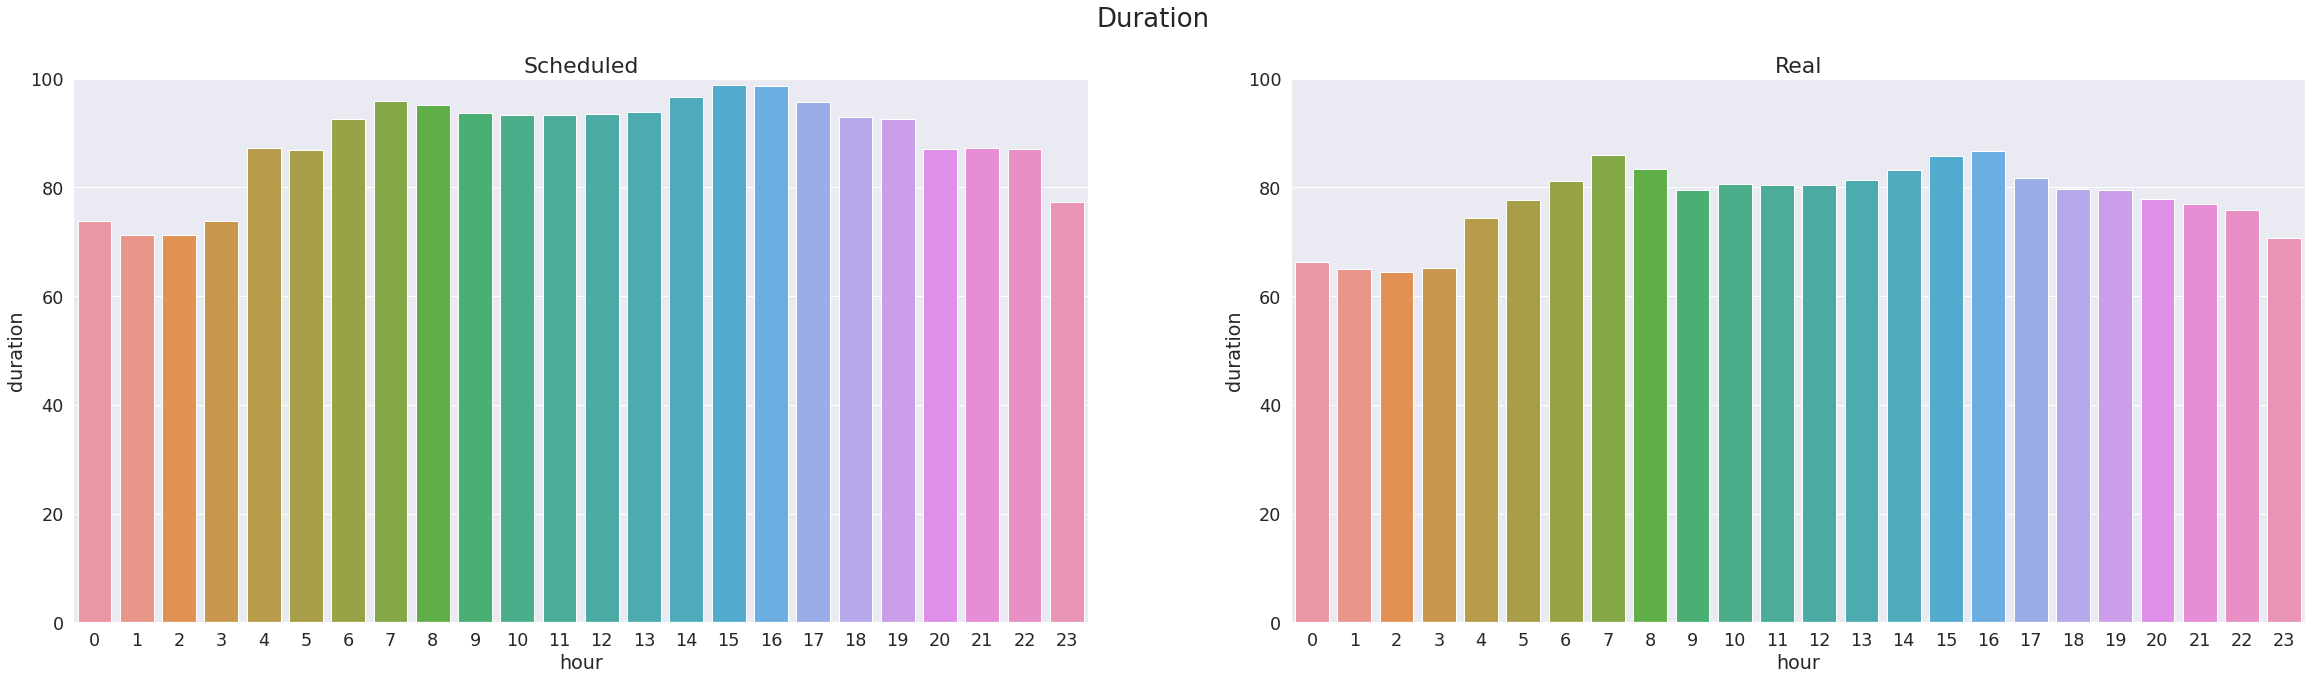

In [250]:
fig, axes = plt.subplots(1, 2, figsize=(40, 10))
sns.barplot(
    data=_routes_df.set_index(['source-target', 'hour']).groupby('hour').mean().reset_index()[['hour', 'duration']], 
    x='hour', y='duration', ax=axes[0]
)
sns.barplot(
    data=_recorded_trips.set_index(['source-target', 'hour']).groupby('hour').mean().reset_index()[['hour', 'duration']], 
    x='hour', y='duration', ax=axes[1]
)
axes[0].set_title("Scheduled", fontsize=22)
axes[1].set_title("Real", fontsize=22)

for ax in axes:
    ax.set_ylim([0, 100])
    
fig.suptitle("Duration", fontsize=26)
plt.savefig("mean_hour_duration.eps")

### velocity (in line dist)

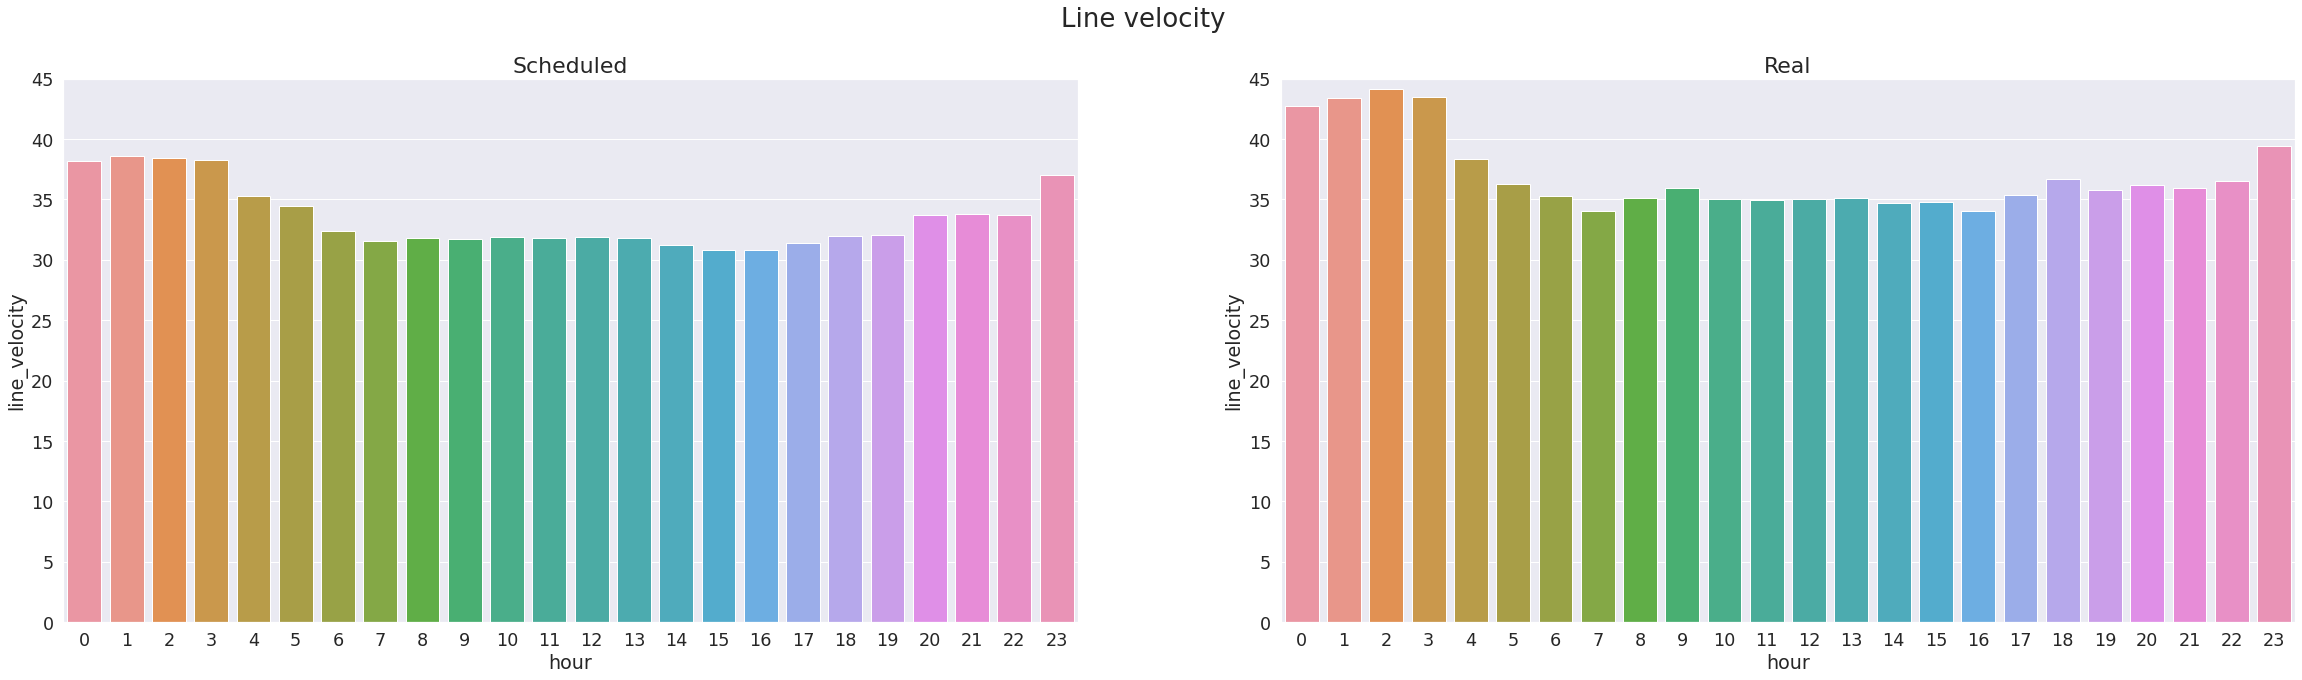

In [251]:
fig, axes = plt.subplots(1, 2, figsize=(40, 10))

sns.barplot(
    data=_routes_df.set_index(['source-target', 'hour']).groupby('hour').mean().reset_index()[['hour', 'line_velocity']], 
    x='hour', y='line_velocity', ax=axes[0]
)
sns.barplot(
    data=_recorded_trips.set_index(['source-target', 'hour']).groupby('hour').mean().reset_index()[['hour', 'line_velocity']], 
    x='hour', y='line_velocity', ax=axes[1]
)
axes[0].set_title("Scheduled", fontsize=22)
axes[1].set_title("Real", fontsize=22)

for ax in axes:
    ax.set_ylim([0, 45])

fig.suptitle("Line velocity", fontsize=26)
plt.savefig("mean_hour_line_velocity.eps")

### velocity (in real dist)

### delay

***

## **Put on map** 

In [ ]:
hours = [0, 4, 8, 12, 16, 20]

In [301]:
def plot_hexbin(city_gdf, routes_df, hour, value_name, fig=None, ax=None, title=None, min_cvalue=None, max_cvalue=None):
    if ax is None or fig is None:
        fig, ax = plt.subplots(figsize=(18, 10))
    x, y = [], []
    for point in routes_df.geometry.values:
        if str(type(point)) != "<class 'NoneType'>":
            x.append(point.coords.xy[0][0])
            y.append(point.coords.xy[1][0])
    values = routes_df[value_name].values
    city_gdf.plot(ax=ax, color='lightgrey', edgecolor='black')
    hexplot = ax.hexbin(x, y, values, cmap='Reds', gridsize=30)
    cbar = fig.colorbar(hexplot, ax=ax)
    cbar.set_label(value_name)
    # if min_cvalue is not None and max_cvalue is not None:
    #     cbar.mappable.set_clim(min_cvalue, max_cvalue)
    if title is not None:
        ax.set_title(f"{title} | {value_name} (hours: {str(hour).zfill(2)} - {str((hour+1)%24).zfill(2)})", fontsize=22)
    else:
        ax.set_title(f"{value_name} (hours: {str(hour).zfill(2)} - {str((hour+1)%24).zfill(2)})", fontsize=22)
        
    ax.set_xlabel("X coord", fontsize=18)
    ax.set_ylabel("Y coord", fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
def plot_hexbin_for_hours(city_gdf, routes_df, value_name, hours, title=''):
    ncols = 3 if len(hours) >=3 else len(hours)
    nrows = math.ceil(len(hours) / ncols)
    xlims = []
    ylims = []
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*13, nrows*10))
    
    for i, hour in enumerate(hours):
        ax = axes[i // ncols, i % ncols] if nrows > 1 else axes[i]
        hour_routes = routes_df[routes_df['hour'] == hour]
        min_cvalue = hour_routes['duration'].min()
        max_cvalue = hour_routes['duration'].max()
        
        plot_hexbin(
            city_gdf, hour_routes, hour=hour, value_name=value_name, fig=fig, ax=ax, min_cvalue=min_cvalue, max_cvalue=max_cvalue
        )
        xlims.extend(list(ax.get_xlim()))
        ylims.extend(list(ax.get_ylim()))

    for ax in axes.flatten():
        ax.set_xlim(min(xlims), max(xlims))
        ax.set_ylim(min(ylims), max(ylims))
    
    fig.suptitle(title, fontsize=26)
    plt.tight_layout()
    plt.savefig(f"mapped_{title}_{value_name}.eps" if title is not None else f"mapped_{value_name}.eps")
    
def compare_real_and_scheduled_hexbin_for_hours(city_gdf, real_df, scheduled_df, value_name, hours):
    xlims = []
    ylims = []
    fig, axes = plt.subplots(len(hours), 2, figsize=(40, len(hours)*10))
    
    for i, hour in enumerate(hours):
        ax1, ax2 = axes[i, 0], axes[i, 1]
        hour_scheduled = scheduled_df[scheduled_df['hour'] == hour]
        hour_real = real_df[real_df['hour'] == hour]
        same_source_stops = list(set(hour_scheduled['source_stop_id'].values).intersection(set(hour_real['source_stop_id'].values)))
        good_scheduled_stops = [stop in same_source_stops for stop in hour_scheduled['source_stop_id'].values]
        good_real_stops = [stop in same_source_stops for stop in hour_real['source_stop_id'].values]
        
        hour_scheduled = hour_scheduled[good_scheduled_stops]
        hour_real = hour_real[good_real_stops]
        
        

        min_cvalue = min([hour_real[value_name].min(), hour_scheduled[value_name].min()])
        max_cvalue = max([hour_real[value_name].max(), hour_scheduled[value_name].max()])
        
        plot_hexbin(city_gdf, hour_scheduled, hour=hour, value_name=value_name, fig=fig, ax=ax1, title="Scheduled", min_cvalue=min_cvalue, max_cvalue=max_cvalue)
        plot_hexbin(city_gdf, hour_real, hour=hour, value_name=value_name, fig=fig, ax=ax2, title="Real", min_cvalue=min_cvalue, max_cvalue=max_cvalue)
        
        xlims.extend(list(ax1.get_xlim()) + list(ax2.get_xlim()))
        ylims.extend(list(ax1.get_ylim()) + list(ax2.get_ylim()))

    for ax in axes.flatten():
        ax.set_xlim(min(xlims), max(xlims))
        ax.set_ylim(min(ylims), max(ylims))

    plt.tight_layout()
    plt.savefig(f"mapped_{value_name}_comparison.eps")

### **duration**

#### Scheduled

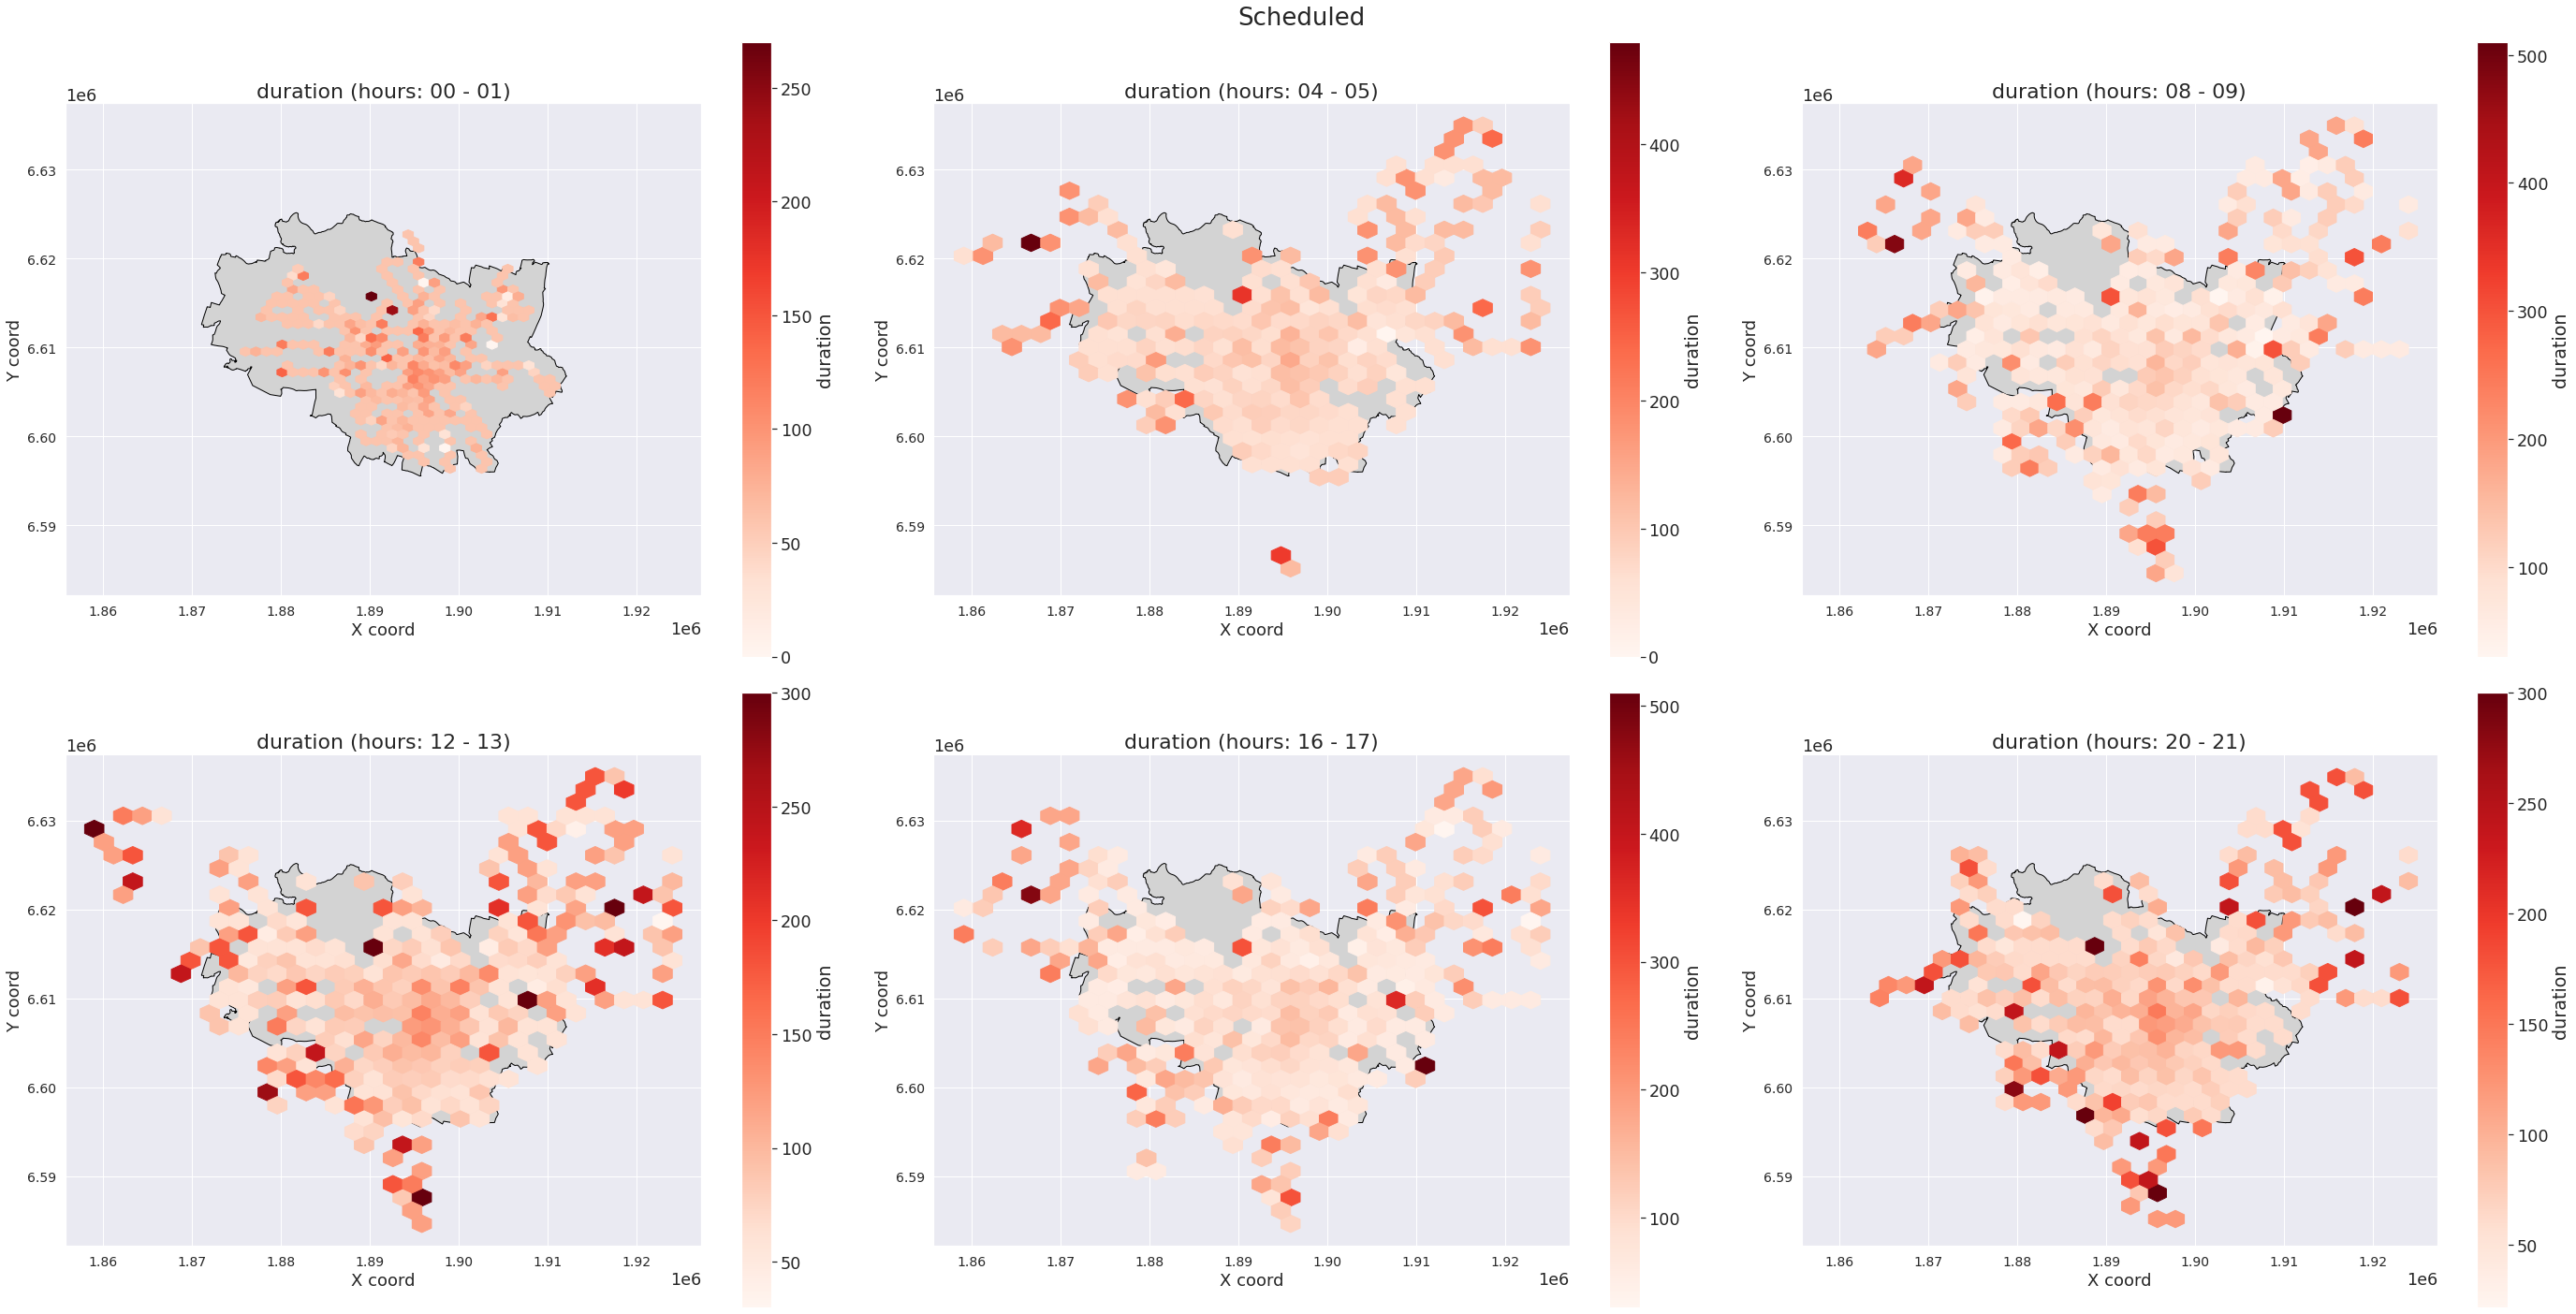

In [302]:
plot_hexbin_for_hours(wroc, _routes_df, value_name='duration', hours=hours, title="Scheduled")

#### Real

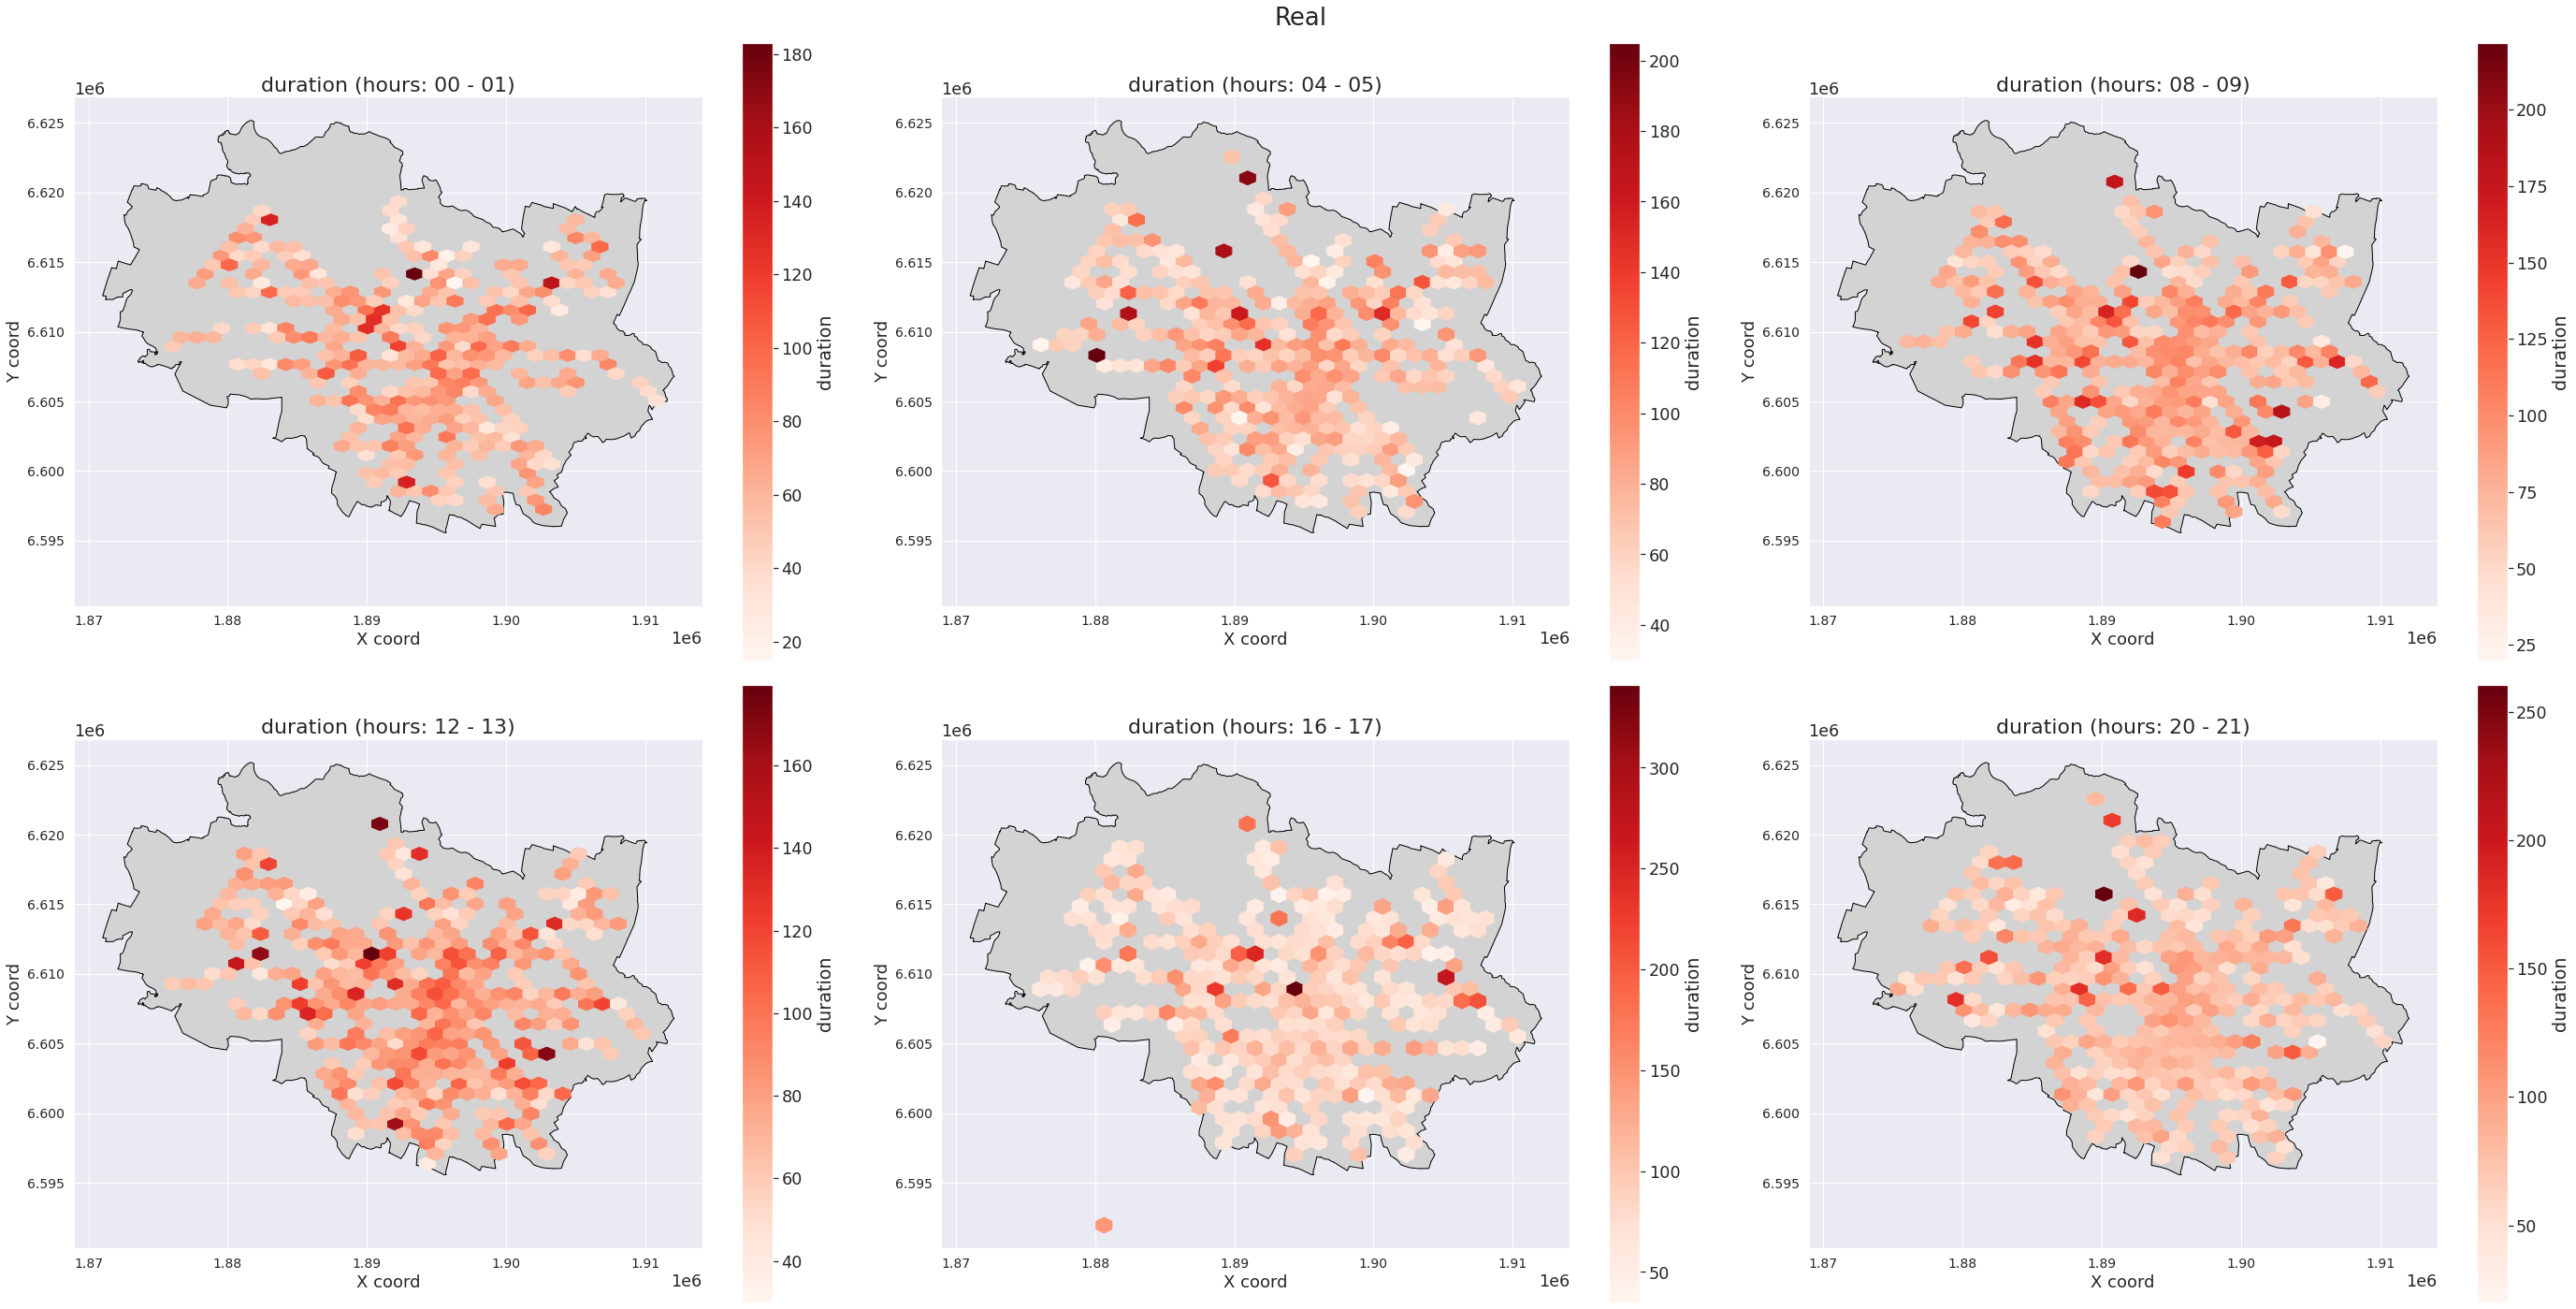

In [303]:
plot_hexbin_for_hours(wroc, _recorded_trips, value_name='duration', hours=hours, title="Real")

#### Comparison

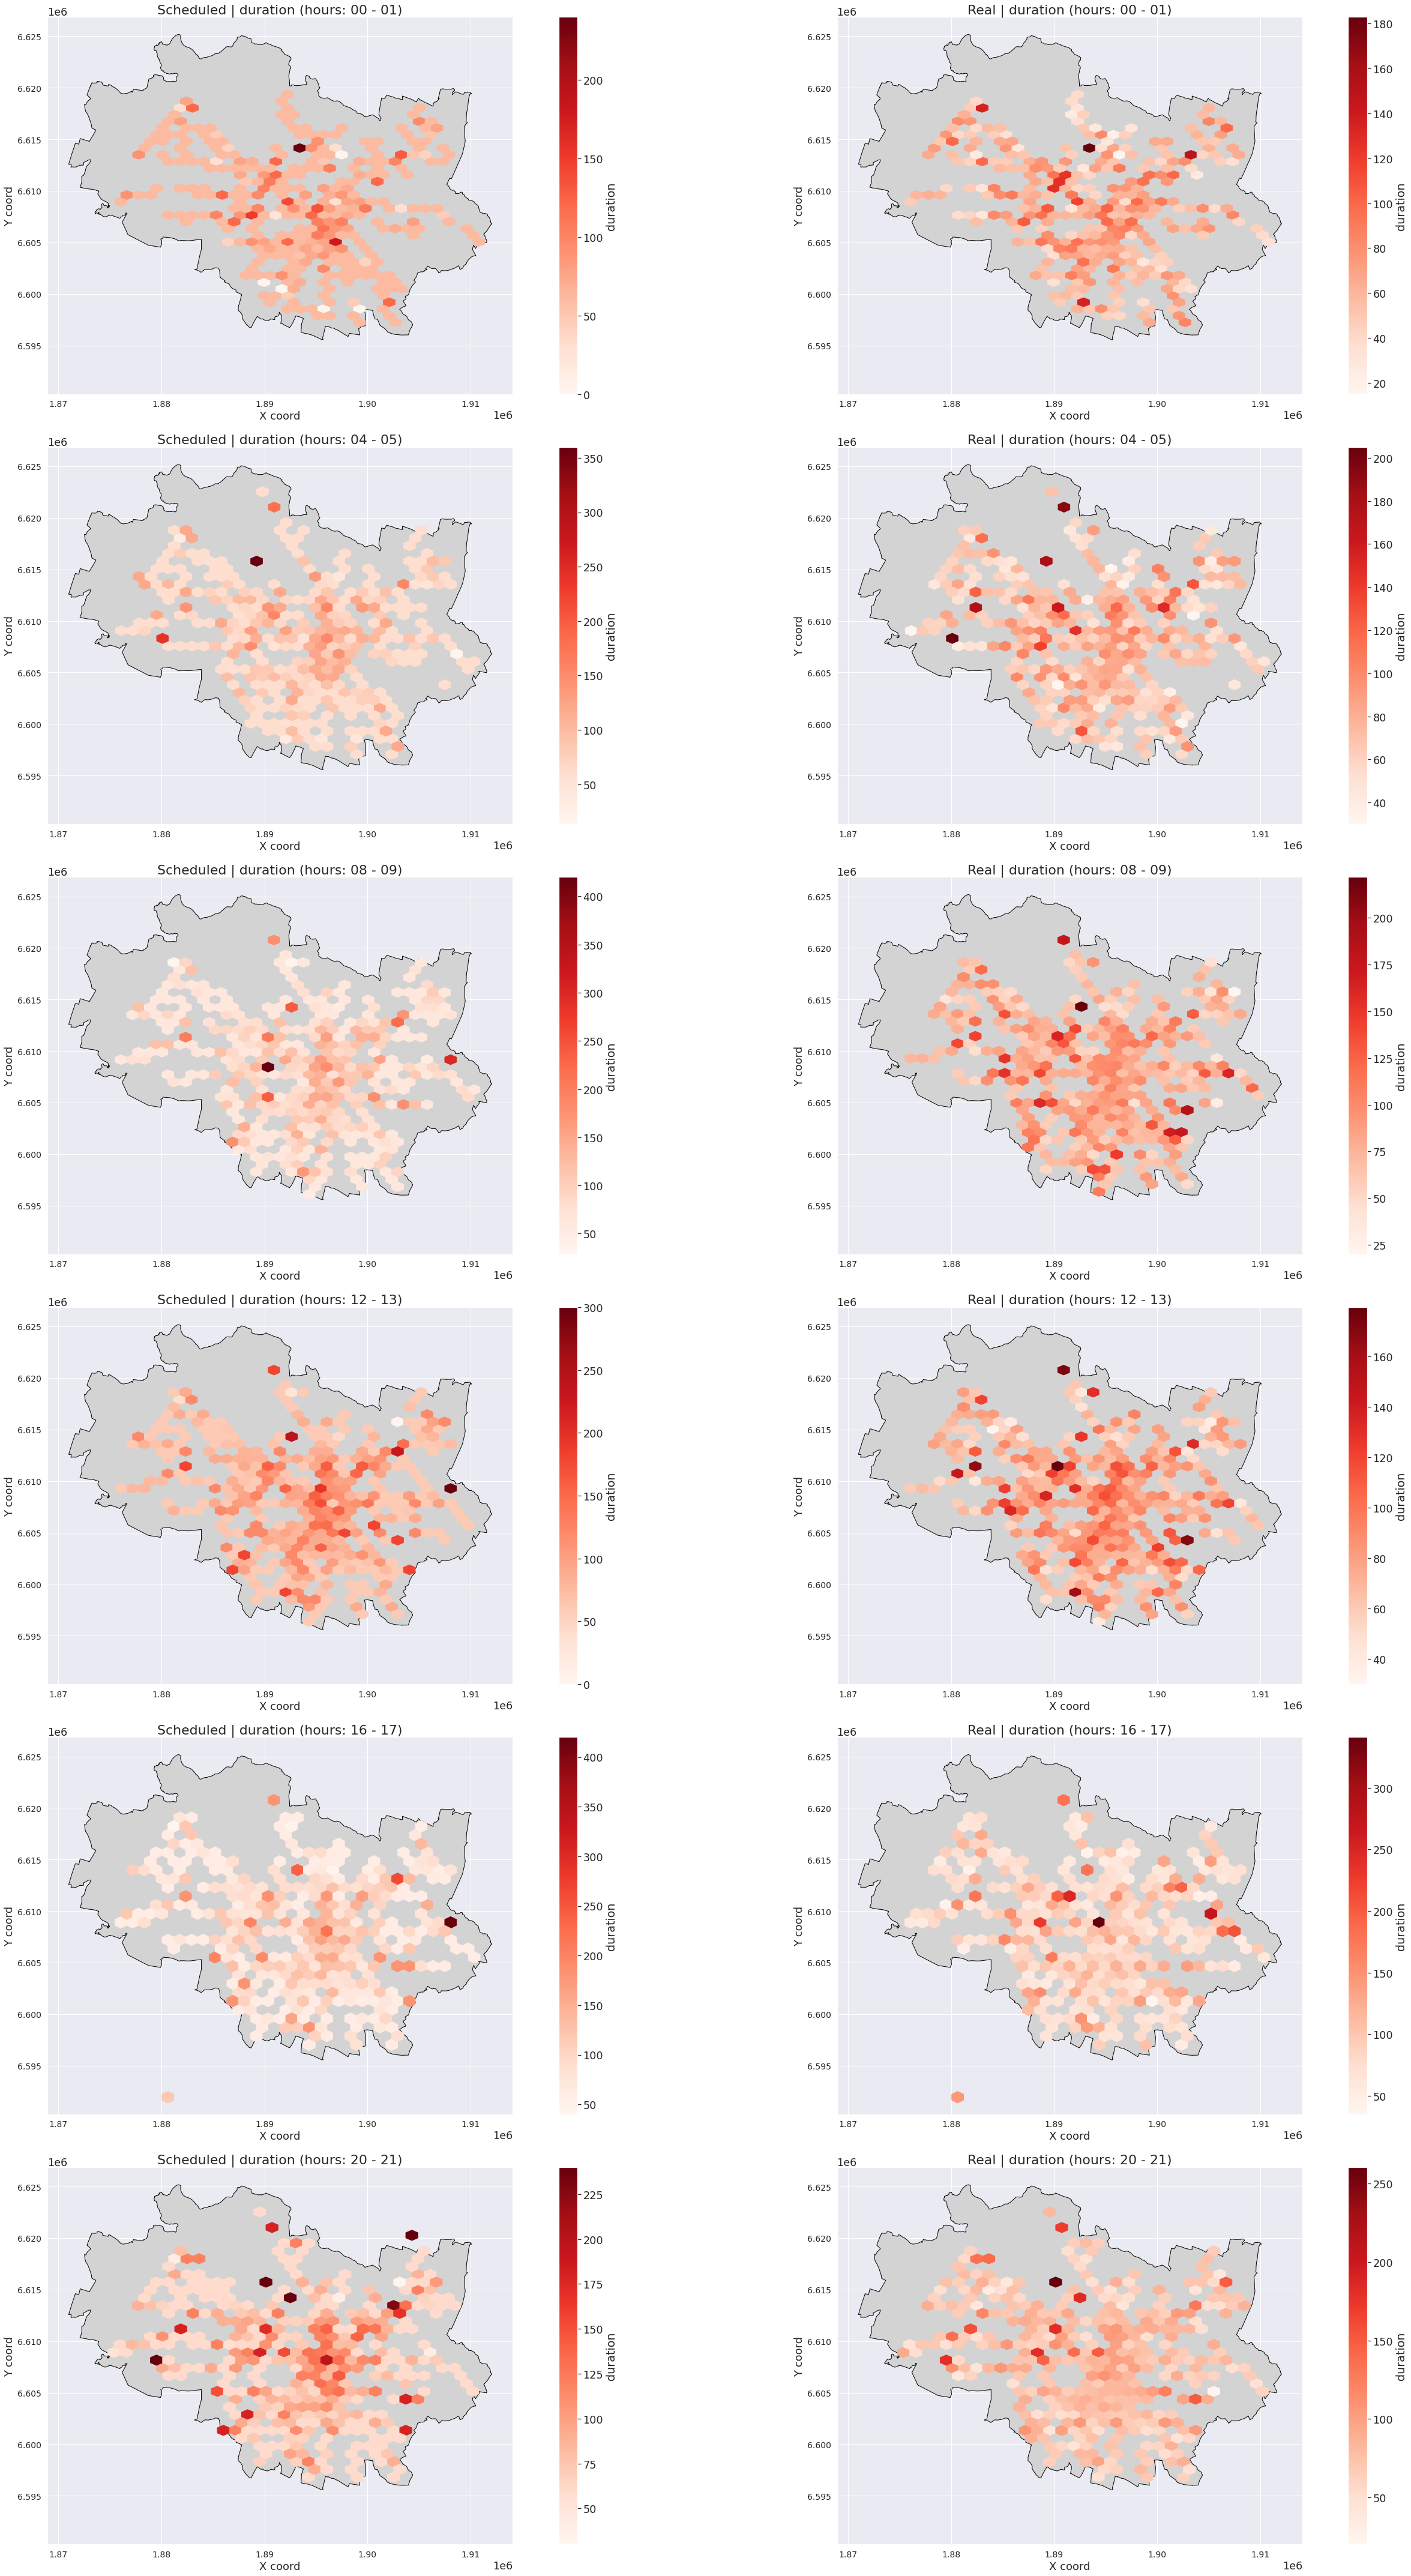

In [284]:
compare_real_and_scheduled_hexbin_for_hours(
    city_gdf=wroc, 
    real_df=_recorded_trips, 
    scheduled_df=_routes_df, 
    value_name='duration', 
    hours=hours
)

---
### **velocity (in line dist)**

#### Scheduled

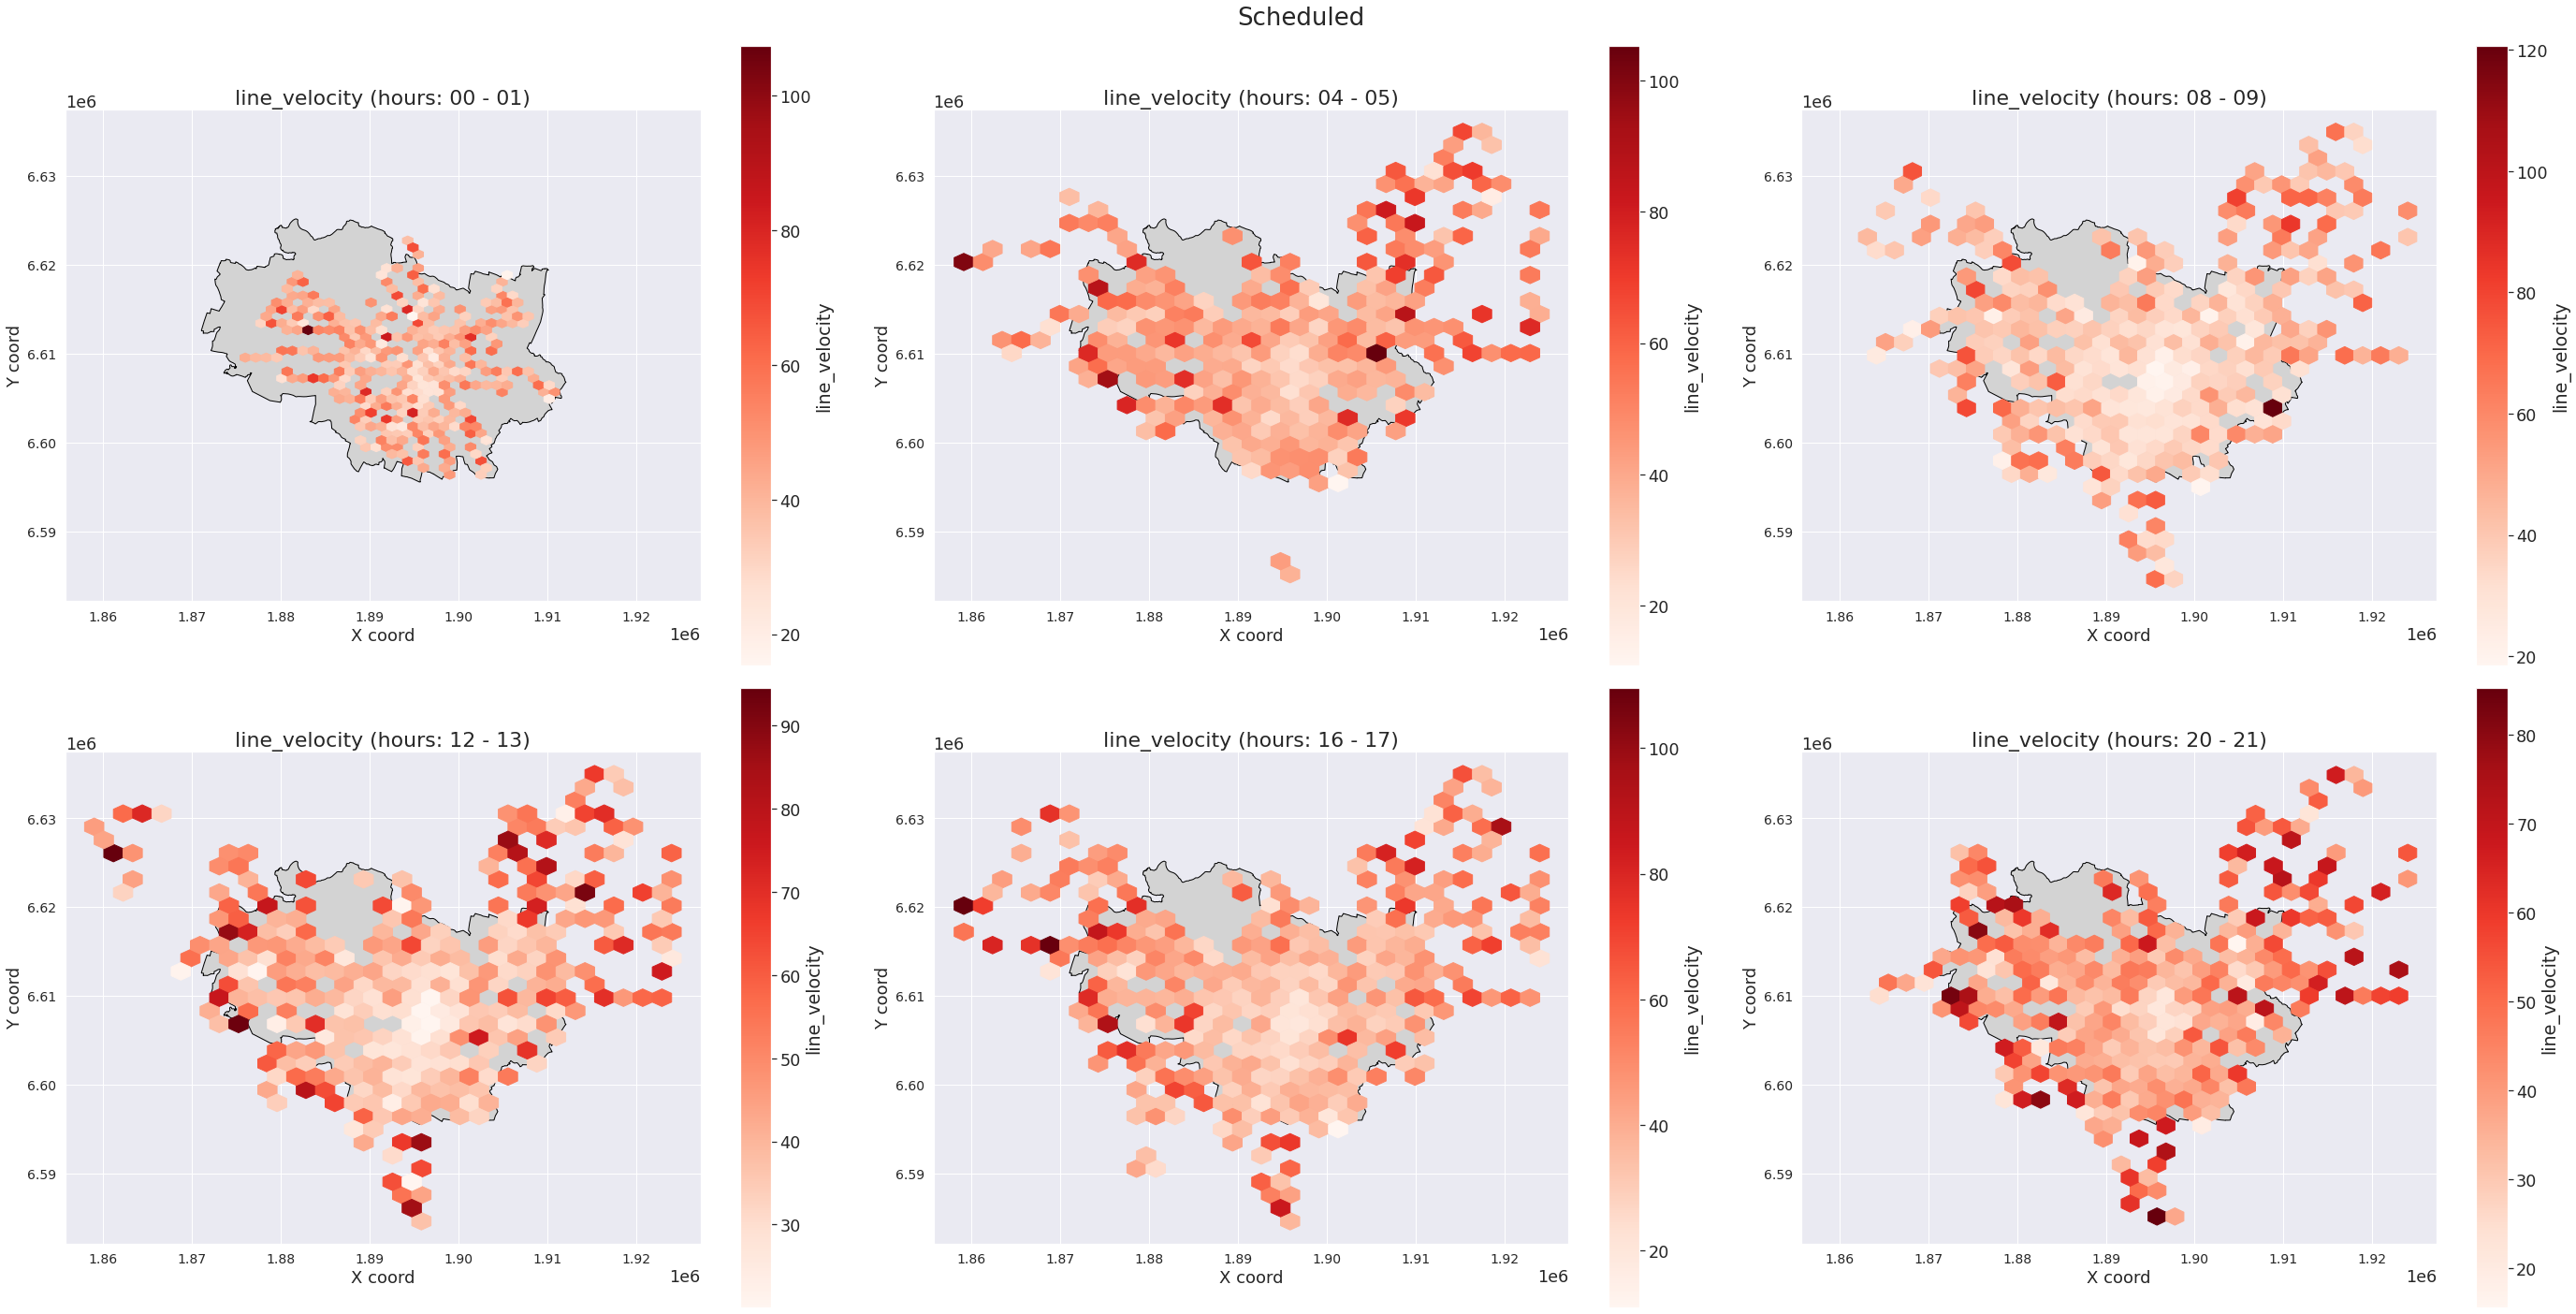

In [304]:
plot_hexbin_for_hours(wroc, _routes_df, value_name='line_velocity', hours=hours, title="Scheduled")

#### Real

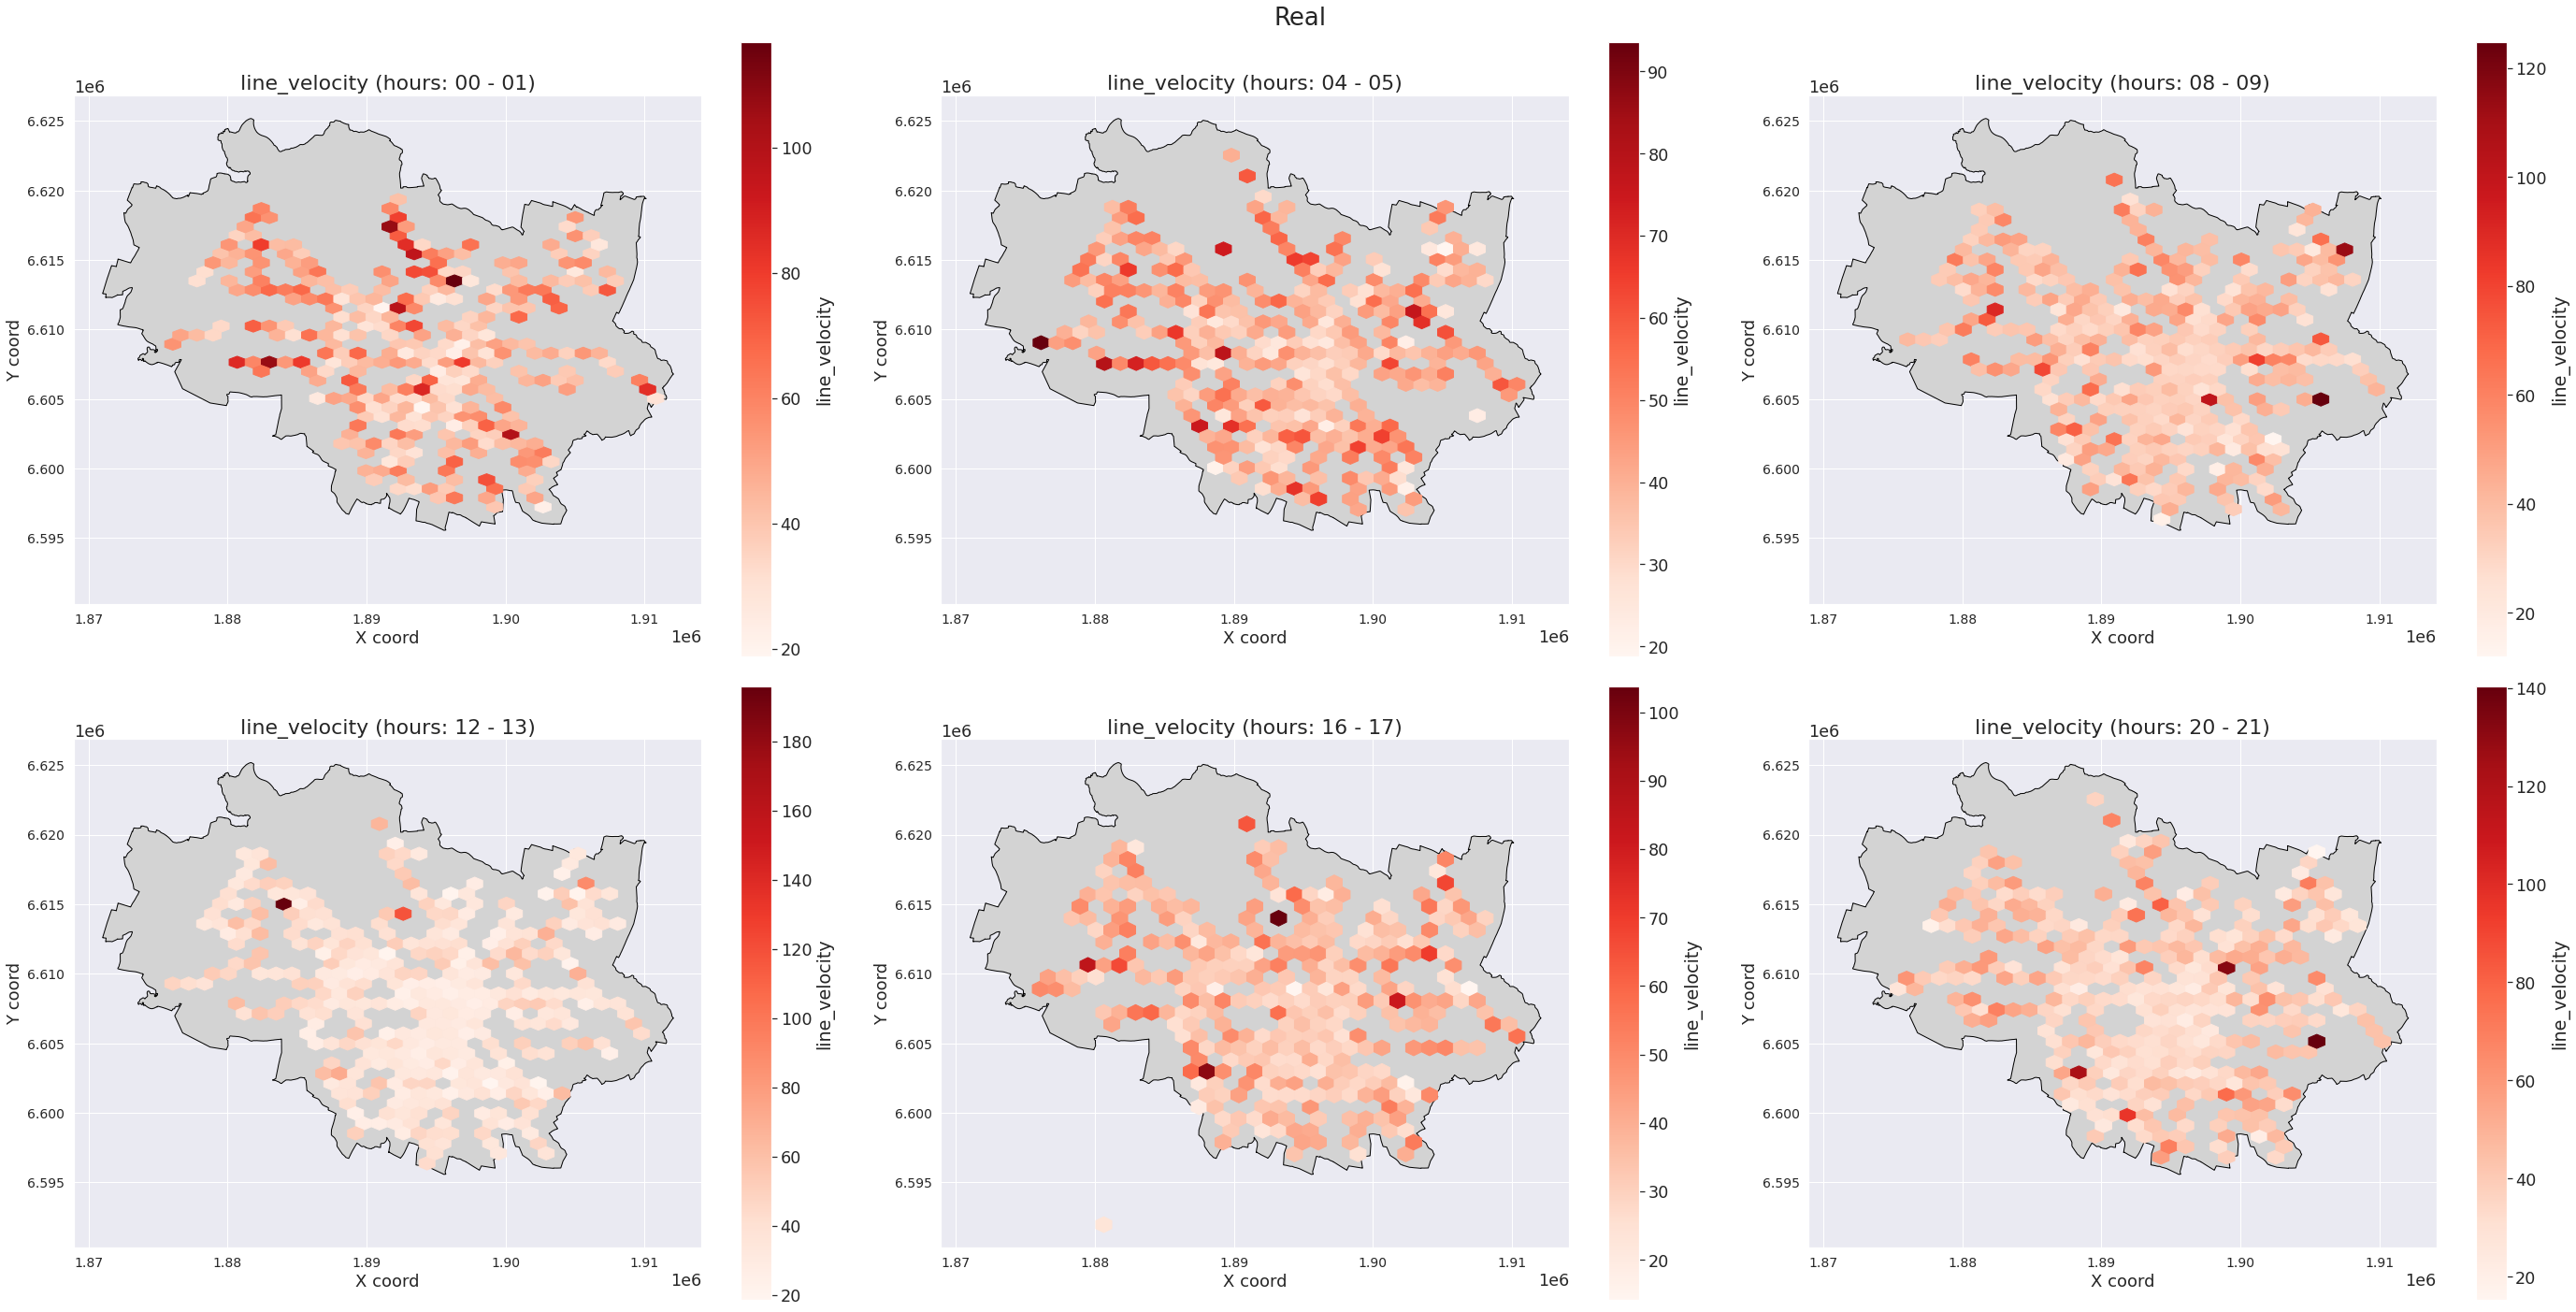

In [305]:
plot_hexbin_for_hours(wroc, _recorded_trips, value_name='line_velocity', hours=hours, title="Real")

#### Comparison

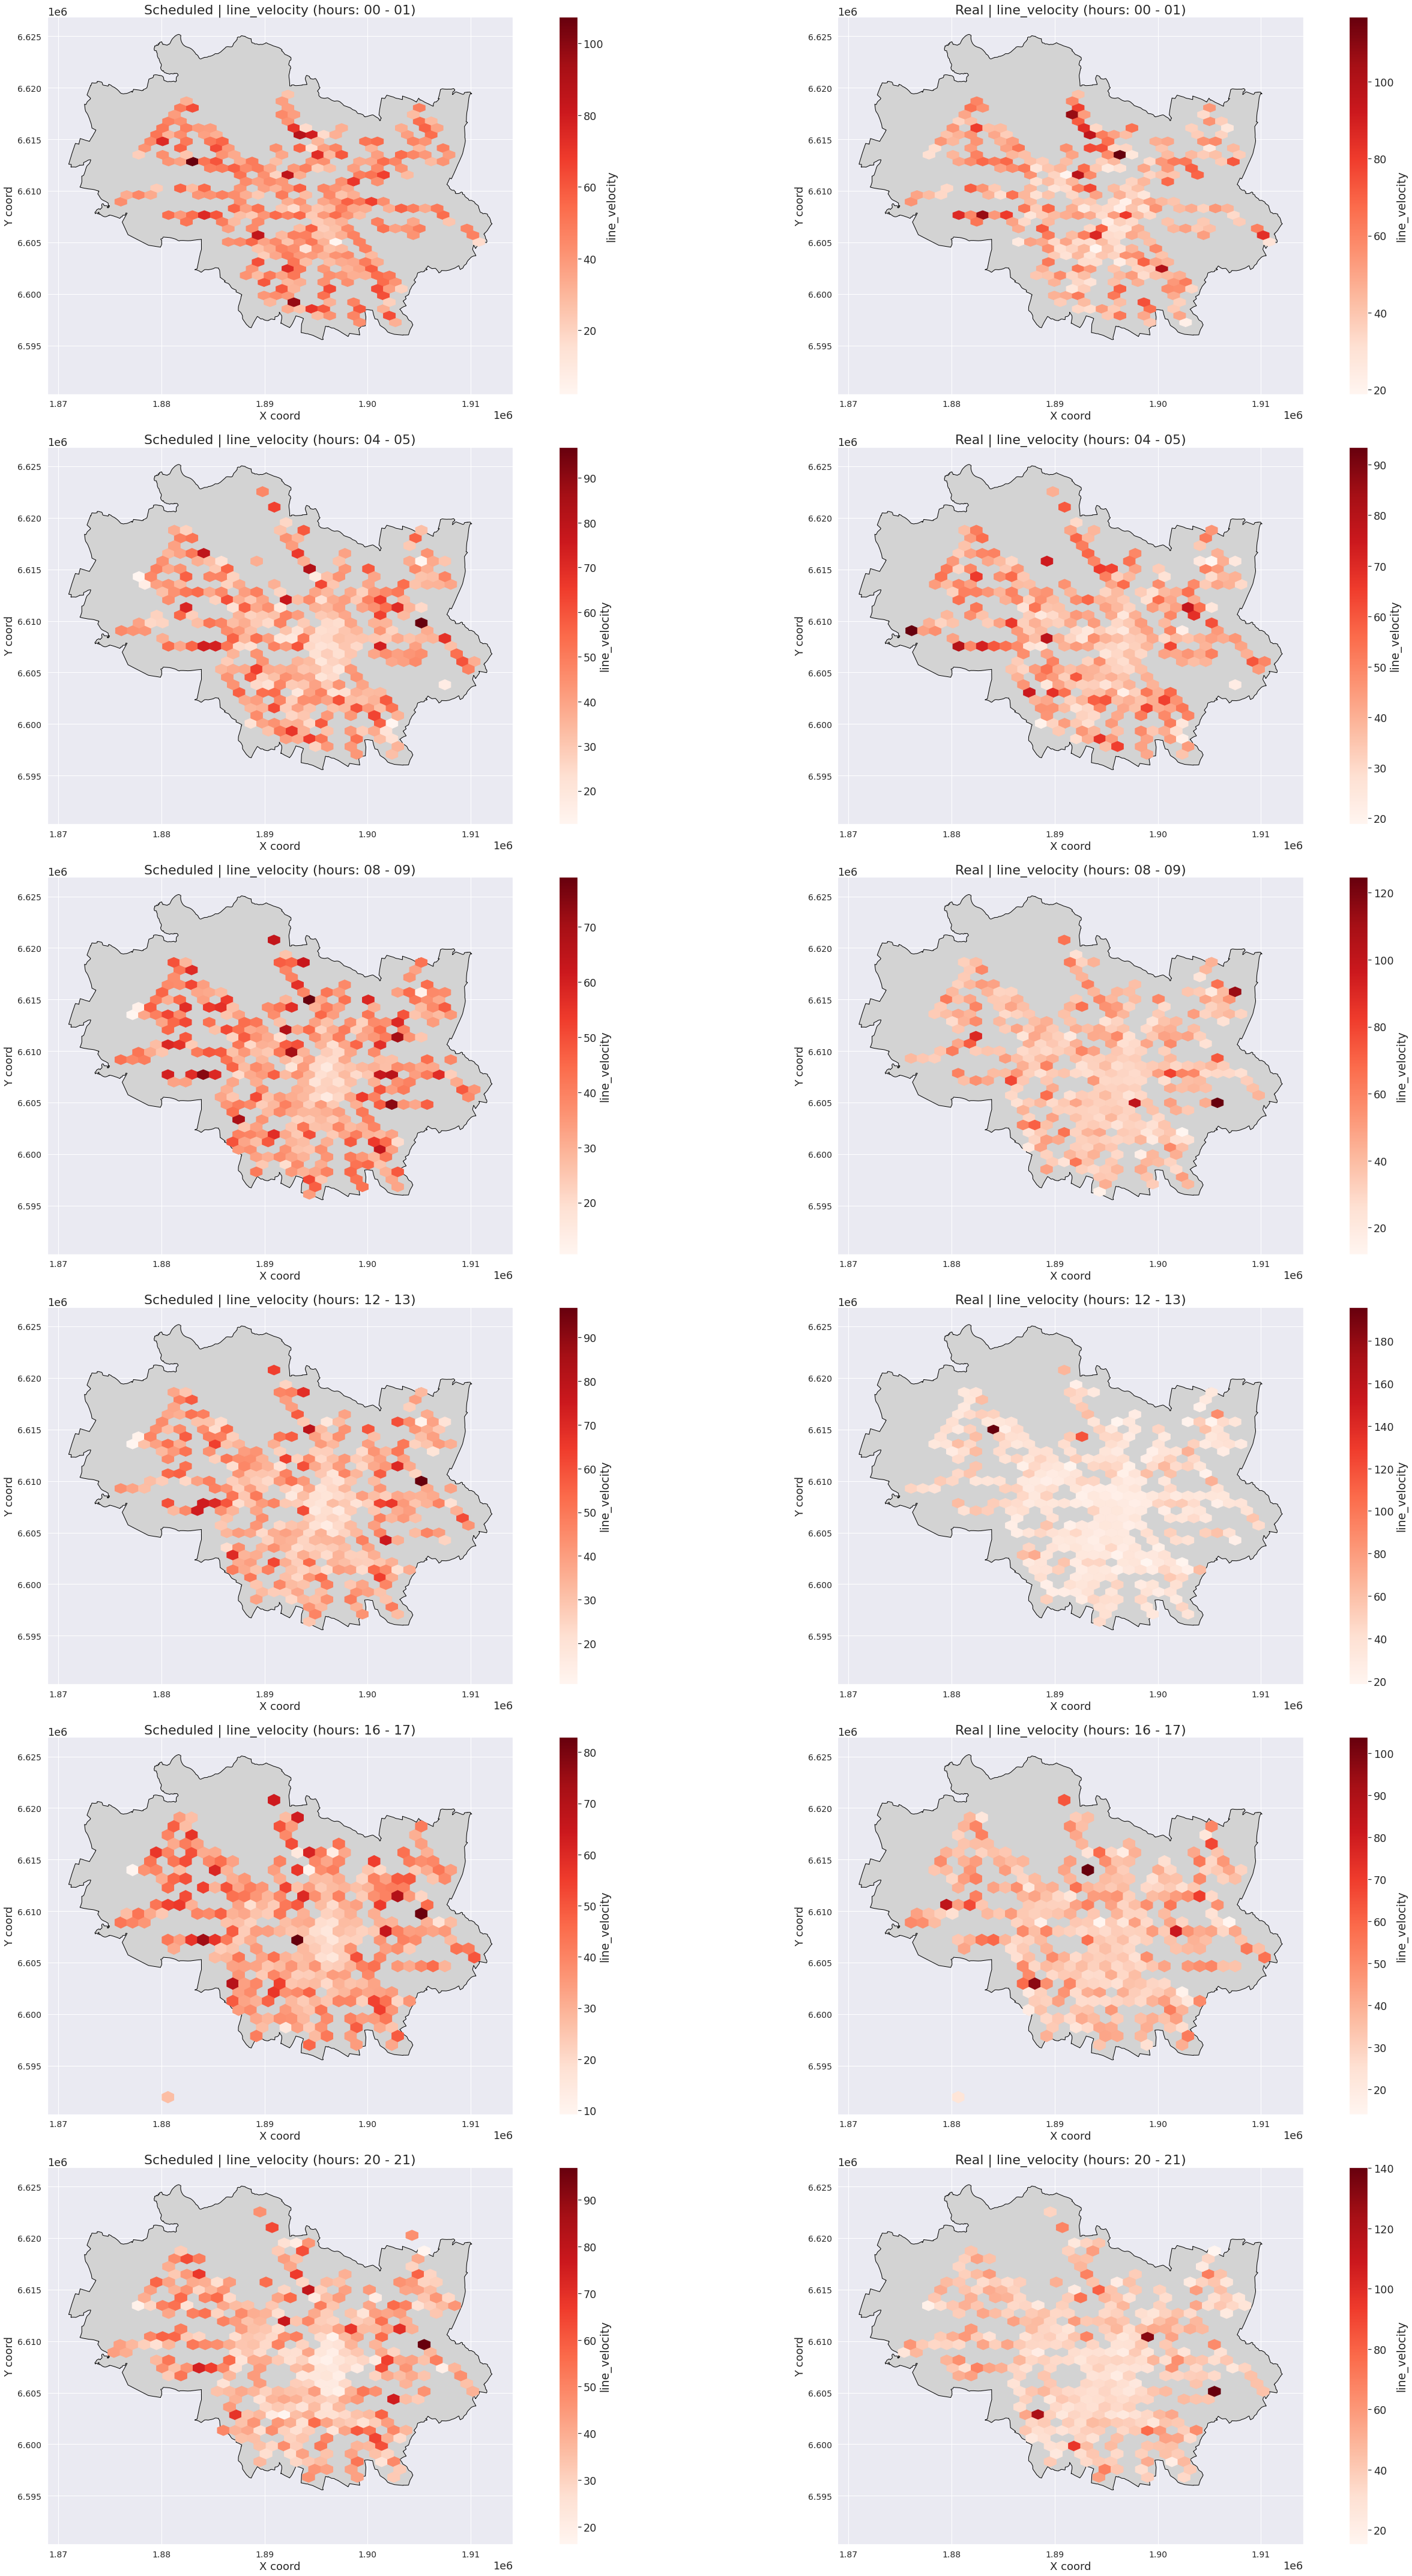

In [287]:
compare_real_and_scheduled_hexbin_for_hours(
    city_gdf=wroc, 
    real_df=_recorded_trips, 
    scheduled_df=_routes_df, 
    value_name='line_velocity', 
    hours=hours
)

### velocity (in real dist)

### delay